In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from joblib import Parallel, delayed
n_jobs = os.cpu_count() - 2
from tqdm.notebook import tqdm
import networkx as nx
import navis
from fafbseg import flywire
import flybrains
flywire.set_default_dataset("public")
import pickle
from scipy.stats import wilcoxon

def p_value_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# make matplotlib plots look better
plt.style.use('dark_background')

Default dataset set to "public".


In [4]:
# create custom colormaps
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
# make a orange to firebrick colormap with white in the middle
c = ['orange', 'firebrick']
v = [0, 1]
cm_ofb = LinearSegmentedColormap.from_list('orange_to_firebrick', list(zip(v, c)))
# make a white to tomato colormap
c = ['white', 'tomato']
v = [0, 1]
cm_wt = LinearSegmentedColormap.from_list('white_to_tomato', list(zip(v, c)))
# create a tab40 colormap with the first 20 colors of the tab20b and tab20c colormaps
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
colors = [tab20b.colors, tab20c.colors]
c = [color for colormap in colors for color in colormap][:40]
cm_tab40 = ListedColormap(c)



In [5]:
# data
data_folder = '../../data/FlyWire/'
processed_data_folder = '../../processed_data/FlyWire/'
figure_folder = '../../processed_data/FlyWire/figures/'
files = os.listdir(data_folder)

In [6]:
skip_connections = True

for f in files:
    if f.endswith('.csv.gz'):
        file_name = f.split('.')[0]
        if skip_connections and 'connections' in file_name:
            continue
        command = file_name+"= pd.read_csv('"+ os.path.join(data_folder, f) +"')"
        exec(command)
        # print(command)

In [7]:
# target connections data
target_connections = 'connections_princeton_no_threshold'
connections = pd.read_csv(os.path.join(data_folder, target_connections + '.csv.gz'))

In [8]:
classification = classification.fillna('')

In [9]:
def get_upstream_synapses(root_id):
    return connections[connections['post_root_id'] == root_id]
    
def get_upstream_neuropil_distribution(root_id):
    # get upstream synapses
    upstream_synapses = get_upstream_synapses(root_id)
    # get upstream neuropils
    neuropils = upstream_synapses['neuropil'].values
    synapse_counts = upstream_synapses['syn_count'].values
    # repeat neuropils according to synapse counts
    neuropils = np.repeat(neuropils, synapse_counts)
    return np.unique(neuropils, return_counts=True)

def get_primary_upstream_neuropil(root_id):
    neuropils, counts = get_upstream_neuropil_distribution(root_id)
    if len(neuropils) == 0:
        return ''
    return neuropils[np.argmax(counts)]

def get_side_from_name(name):
    if '_L' in name:
        return 'left'
    if '_R' in name:
        return 'right'
    return 'center'

In [10]:
def get_neuron_class(root_id):
    return classification[classification['root_id'] == root_id]['class'].values[0]

def simplify_cell_type(cell_type):
    # if the cell type has multiple ones separated by a comma, split them
    if ',' not in cell_type:
        return cell_type
    else:
        units = [x.strip() for x in cell_type.split(',')]
        # they might have a the initial part in common, find it
        common = os.path.commonprefix(units)
        # remove the common part from each unit and then join them using '/'
        return common + '/'.join([u.replace(common, '') for u in units])

def get_cell_type(root_id):
    hemibrain_type = classification[classification['root_id'] == root_id]['hemibrain_type'].values[0]
    if hemibrain_type == '':
        cell_type = classification[classification['root_id'] == root_id]['cell_type'].values[0]
        return simplify_cell_type(cell_type)
    else:
        return simplify_cell_type(hemibrain_type)

# replace empty classes with 'other' + superclasses
ids_to_replace = classification['class'] == ''
classification.loc[ids_to_replace, 'class'] = 'other ' + classification.loc[ids_to_replace, 'super_class']

# add clean cell types to the classification
classification['clean_cell_type'] = classification['root_id'].apply(get_cell_type)

# find connections from one set of roots to another
def find_connections(pre_root_ids, post_root_ids):
    connections_from_pre = connections[connections['pre_root_id'].isin(pre_root_ids)].copy().reset_index(drop=True)
    connections_from_pre = connections_from_pre[connections_from_pre['post_root_id'].isin(post_root_ids)]
    # merge connections from same pre and post neurons
    connections_from_pre = connections_from_pre.groupby(['pre_root_id', 'post_root_id']).agg({'syn_count': 'sum'}).reset_index()
    return connections_from_pre

def find_connection_strengths(pre_root_ids, post_root_ids):
    connections_from_pre = connections[connections['pre_root_id'].isin(pre_root_ids)].copy().reset_index(drop=True)
    connections_from_pre = connections_from_pre[connections_from_pre['post_root_id'].isin(post_root_ids)]
    # merge connections from same pre and post neurons
    connections_from_pre = connections_from_pre.groupby(['pre_root_id', 'post_root_id']).agg({'syn_strength': 'sum'}).reset_index()
    return connections_from_pre

def get_cell_side(root_id):
    return classification[classification['root_id'] == root_id]['side'].values[0]

# find the roots by cell type
def find_roots_by_cell_type(cell_type):
    classifieds = classification[classification['clean_cell_type'] == cell_type]
    return classifieds['root_id'].values

In [11]:
neuron_dictionary = {
    "MBON01": "MBON-γ5β′2a",
    "MBON02": "MBON-β2β′2a",
    "MBON03": "MBON-β′2mp",
    "MBON04": "MBON-β′2mp bilateral",
    "MBON05": "MBON-γ4>γ1γ2",
    "MBON06": "MBON-β1>α",
    "MBON07": "MBON-α1",
    "MBON08": "MBON-γ3",
    "MBON09": "MBON-γ3β′1",
    "MBON10": "MBON-β′1",
    "MBON11": "MBON-γ1pedc>α/β",
    "MBON12": "MBON-γ2α′1",
    "MBON13": "MBON-α′2",
    "MBON14": "MBON-α3",
    "MBON15": "MBON-α′1",
    "MBON16": "MBON-α′3ap",
    "MBON17": "MBON-α′3m",
    "MBON18": "MBON-α2sc",
    "MBON19": "MBON-α2p3p",
    "MBON20": "MBON-γ1γ2",
    "MBON21": "MBON-γ4γ5",
    "MBON22": "MBON-calyx",
    "MBON23": "MBON-α2sp",
    "MBON24": "MBON-β2γ5",
    "MBON25": "MBON-γ1γ2",
    "MBON26": "MBON-β′2d",
    "MBON27": "MBON-γ5d",
    "MBON28": "MBON-α′3a",
    "MBON29": "MBON-γ4γ5",
    "MBON30": "MBON-γ1γ2γ3",
    "MBON31": "MBON-α′1a",
    "MBON32": "MBON-γ2",
    "MBON33": "MBON-γ2γ3",
    "MBON34": "MBON-γ2",
    "MBON35": "MBON-γ2",
    "PAM01": "PAM-γ5",
    "PAM02": "PAM-β′2a",
    "PAM03": "PAM-β2β′2a",
    "PAM04": "PAM-β2",
    "PAM05": "PAM-β′2p",
    "PAM06": "PAM-β′2m",
    "PAM07": "PAM-γ4<γ1γ2",
    "PAM08": "PAM-γ4",
    "PAM09": "PAM-β1ped",
    "PAM10": "PAM-β1",
    "PAM11": "PAM-α1",
    "PAM12": "PAM-γ3",
    "PAM13": "PAM-β′1 ap",
    "PAM14": "PAM-β′1 m",
    "PPL101": "PPL1-γ1pedc",
    "PPL102": "PPL1-γ1‡‡",
    "PPL103": "PPL1-γ2α′1",
    "PPL104": "PPL1-α′3",
    "PPL105": "PPL1-α′2α2",
    "PPL106": "PPL1-α3",
    "PPL201": "PPL2-a"  
}

In [12]:
def network_influence_propagate(input_root_ids, input_values, exclude_downstream=None):
    # find all downstream connections
    downstream_connections = connections[connections['pre_root_id'].isin(input_root_ids)].copy().reset_index(drop=True)
    # remove connections with invalid synapse strength
    downstream_connections = downstream_connections[np.logical_not(np.isnan(downstream_connections['syn_strength']))]
    downstream_connections = downstream_connections[np.logical_and(downstream_connections['syn_strength'] > 0, downstream_connections['syn_strength'] < 1)]
    if exclude_downstream is not None:
        # remove excluded downstream neurons
        downstream_connections = downstream_connections[np.logical_not(downstream_connections['post_root_id'].isin(exclude_downstream))]
    # find all downstream neurons
    downstream_neurons = np.unique(downstream_connections['post_root_id'])
    # create a mapping from root id to index
    root_to_input = {r:i for i,r in enumerate(input_root_ids)}
    root_to_output = {r:i for i,r in enumerate(downstream_neurons)}
    # create a connectivity matrix
    connection_matrix = np.zeros((len(downstream_neurons), len(input_root_ids)))
    connection_counts = np.zeros((len(downstream_neurons), len(input_root_ids)))
    # fill the matrix
    for i in tqdm(downstream_connections.index):
        pre_id = downstream_connections.loc[i, 'pre_root_id']
        post_id = downstream_connections.loc[i, 'post_root_id']
        pre_index = root_to_input[pre_id]
        post_index = root_to_output[post_id]
        if connection_matrix[post_index, pre_index] == 0:
            connection_matrix[post_index, pre_index] = downstream_connections.loc[i, 'syn_strength']
        else:
            connection_matrix[post_index, pre_index] += downstream_connections.loc[i, 'syn_strength']
        connection_counts[post_index, pre_index] += 1
    # calculate the geometric mean of the connections
    # make zeros 1
    # connection_counts[connection_counts == 0] = 1
    # connection_matrix = np.power(connection_matrix, 1/connection_counts)
    # propagate the values
    output_values = np.dot(connection_matrix, input_values)
    # mixing strength (variance of the inputs received by each neuron)
    mixing_strength = np.std(connection_matrix*input_values, axis=1)
    return downstream_neurons, output_values, mixing_strength

In [13]:
# get all sugar GRNs (class = 'gustatory', subclass = 'sugar/water')
sugar_grn_roots = classification[(classification['class'] == 'gustatory') & (classification['sub_class'] == 'sugar/water')]['root_id'].values

# create the GRN_connectivity directory and the figures directory
GRN_connectivity_folder = os.path.join(processed_data_folder, 'GRN_connectivity')
if not os.path.exists(GRN_connectivity_folder):
    os.makedirs(GRN_connectivity_folder)
GRN_connectivity_figures = os.path.join(figure_folder, 'GRN_connectivity')
if not os.path.exists(GRN_connectivity_figures):
    os.makedirs(GRN_connectivity_figures)


In [14]:
recalculate = False

In [15]:
input_values = np.ones(len(sugar_grn_roots))

N_steps = 3
exclude_visited = False

layers = []
connectivitys = []
mixing_strengths = []

visited_neurons = np.array([])

output_values = input_values
downstream_neurons = sugar_grn_roots
mixing_strength = np.zeros(len(downstream_neurons))

for i in range(N_steps):
    layers.append(downstream_neurons)
    connectivitys.append(output_values)
    mixing_strengths.append(mixing_strength)

    if exclude_visited:
        # add the downstream neurons to the visited neurons
        visited_neurons = np.concatenate((visited_neurons, downstream_neurons))
        # make sure the visited neurons are unique
        visited_neurons = np.unique(visited_neurons)

    print('Step', i, end=': ')
    if os.path.exists(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_downstream_neurons_step_{}.npy'.format(i))) and not recalculate:
        print('Data exists. Loading... ', end='')
        output_values = np.load(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_output_values_step_{}.npy'.format(i)))
        downstream_neurons = np.load(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_downstream_neurons_step_{}.npy'.format(i)))
        mixing_strength = np.load(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_mixing_strength_step_{}.npy'.format(i)))
        print('N={}'.format(len(downstream_neurons)), end=' ')
        print('Done.')
    else:
        print('Propagating... ', end='')
        downstream_neurons, output_values, mixing_strength = network_influence_propagate(downstream_neurons, output_values, exclude_downstream=visited_neurons if exclude_visited else None)
        np.save(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_output_values_step_{}.npy'.format(i)), output_values)
        np.save(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_downstream_neurons_step_{}.npy'.format(i)), downstream_neurons)
        np.save(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_mixing_strength_step_{}.npy'.format(i)), mixing_strength)
        print('N={}'.format(len(downstream_neurons)), end=' ')
        print('Done.')

# add the last step
layers.append(downstream_neurons)
connectivitys.append(output_values)
mixing_strengths.append(mixing_strength)


Step 0: Data exists. Loading... N=946 Done.
Step 1: Data exists. Loading... N=34437 Done.
Step 2: Data exists. Loading... N=130807 Done.


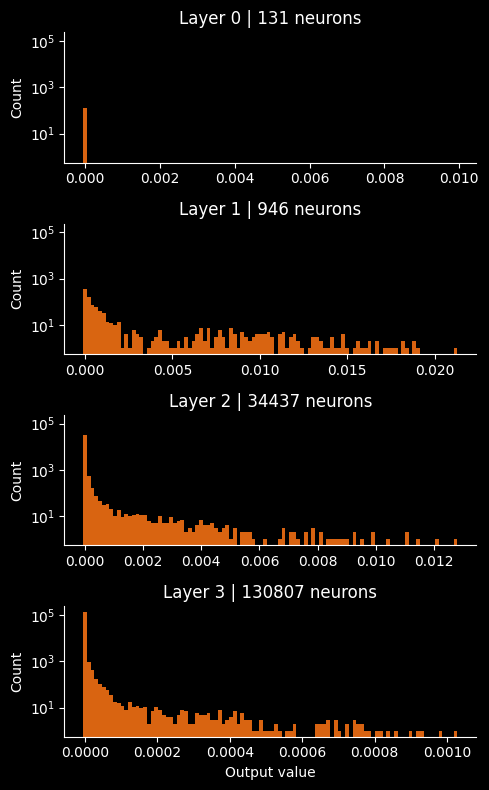

In [16]:
# plot the values (histogram) for each step
fig,ax = plt.subplots(N_steps+1,1,figsize=(5,8), sharey=True)
for i in range(N_steps+1):
    if np.all(mixing_strengths[i] == 0):
        bins, edges = np.histogram(mixing_strengths[i], bins=np.linspace(0, 0.01, 100))
    else:
        bins, edges = np.histogram(mixing_strengths[i], bins=100)
    max_connectivity = np.max(mixing_strengths[i])
    ax[i].bar(edges[:-1], bins, width=np.diff(edges), color=cm_ofb(np.linspace(0.5-max_connectivity/2, 0.5+max_connectivity/2, 100)))
    ax[i].set_title('Layer {} | {} neurons'.format(i, len(layers[i])))
    ax[i].set_ylabel('Count')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_yscale('log') 
ax[N_steps].set_xlabel('Output value')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_transmission.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [17]:
layer_classes = [[get_neuron_class(n) for n in tqdm(layer)] for layer in layers]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/946 [00:00<?, ?it/s]

  0%|          | 0/34437 [00:00<?, ?it/s]

  0%|          | 0/130807 [00:00<?, ?it/s]

Layer 1

Unique visited neurons: 946


/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_46949/1721974587.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_values, -i + 0.2*np.random.randn(len(class_values)), c=cm_tab40(i), s=1)


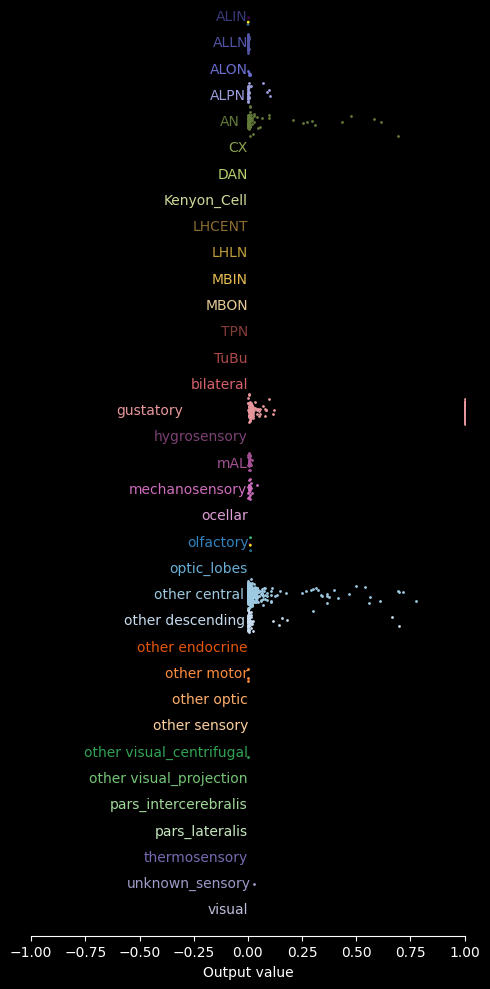

Layer 2

Unique visited neurons: 34437


/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_46949/1721974587.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_values, -i + 0.2*np.random.randn(len(class_values)), c=cm_tab40(i), s=1)


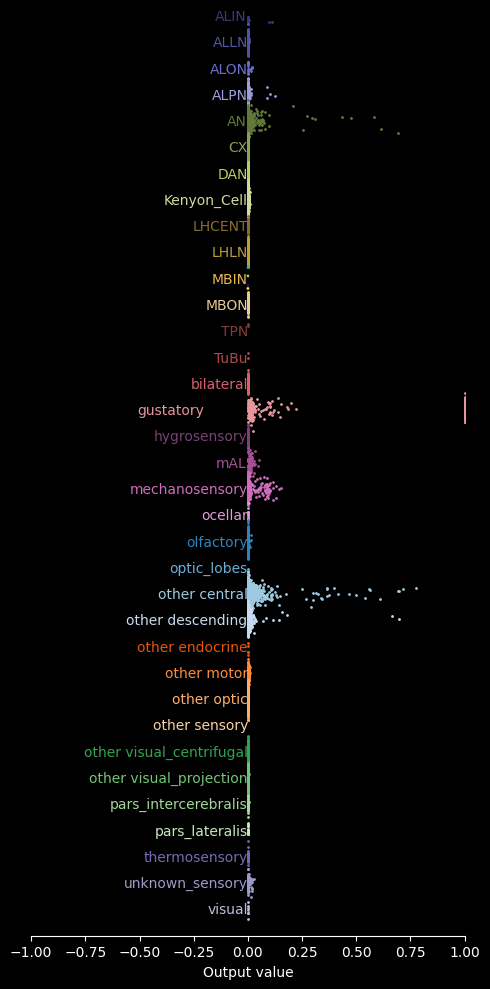

Layer 3

Unique visited neurons: 130807


/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_46949/1721974587.py:40: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_values, -i + 0.2*np.random.randn(len(class_values)), c=cm_tab40(i), s=1)


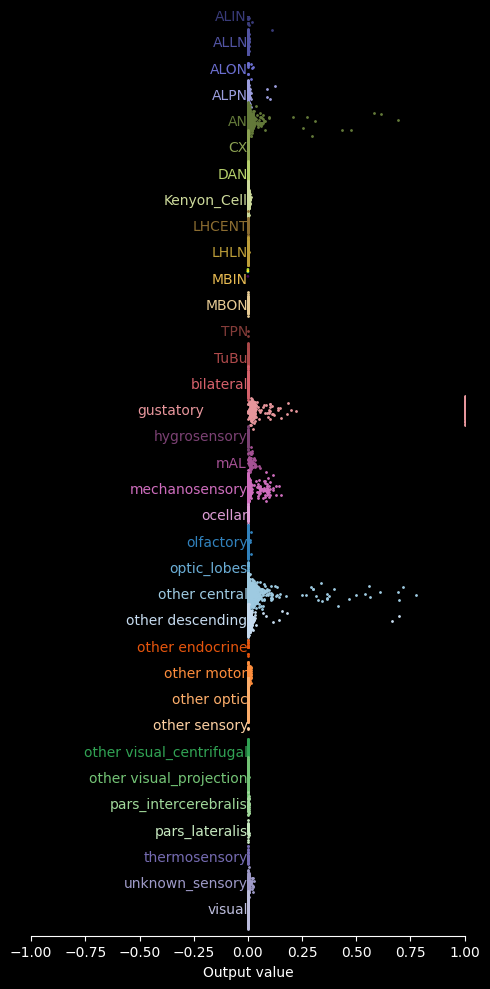

In [18]:
visited_neurons = layers[0]
visited_values = connectivitys[0]
visited_classes = layer_classes[0]

classes = np.unique(classification['class'].values)

n_classes = len(classes)
class_to_index = {c:i for i,c in enumerate(classes)}
index_to_class = {i:c for i,c in enumerate(classes)}

for layer_no in range(1,N_steps+1):
    print('Layer', layer_no, end='\n\n')
    
    neurons = layers[layer_no]
    values = connectivitys[layer_no]
    classes = layer_classes[layer_no]

    # add the visited neurons to the visited neurons
    visited_neurons = np.concatenate((visited_neurons, neurons))
    visited_values = np.concatenate((visited_values, values))
    visited_classes = np.concatenate((visited_classes, classes))
    # make sure the visited neurons are unique
    unique_visited_neurons = np.unique(visited_neurons)
    print('Unique visited neurons:', len(unique_visited_neurons))
    # get the max value for each visited neuron
    visited_values_max_index = np.array([np.argmax(np.abs(visited_values[visited_neurons == n])) for n in unique_visited_neurons])
    visited_values = np.array([visited_values[visited_neurons == n][i] for n,i in zip(unique_visited_neurons, visited_values_max_index)])
    visited_classes = np.array([visited_classes[visited_neurons == n][0] for n in unique_visited_neurons])
    visited_neurons = unique_visited_neurons

    class_ids = [class_to_index[c] for c in visited_classes]
    class_ids = np.array(class_ids)

    # scatter plot of the values
    plt.figure(figsize=(5,10))
    for i in range(n_classes):
        # get the values for the class
        class_values = visited_values[class_ids == i]
        # plot the values
        plt.scatter(class_values, -i + 0.2*np.random.randn(len(class_values)), c=cm_tab40(i), s=1)
        # put the name of the class next to the points
        plt.text(np.nanmin(class_values)-0.5*np.mean(np.abs(class_values)) if len(class_values) > 0 else 0, -i, index_to_class[i], verticalalignment='center', horizontalalignment='right', fontsize=10, color=cm_tab40(i))
    max_value = np.max(np.abs(visited_values))
    plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    plt.ylim(-n_classes, 0)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_class_layer_{}.pdf'.format(layer_no)), bbox_inches='tight', dpi=300)
    plt.show()

In [19]:
# get cell types of each neuron
visited_cell_types = [get_cell_type(n) for n in visited_neurons]
# use neuron_dictionary to replace the cell types with the names if they are in the dictionary
visited_cell_types = [neuron_dictionary.get(ct, ct) for ct in visited_cell_types]
# save the max connectivity metrics
max_connectivity_metrics = pd.DataFrame({
    'root_id': visited_neurons,
    'max_connectivity': visited_values,
    'class': visited_classes,
    'cell_type': visited_cell_types
})

max_connectivity_metrics.to_csv(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_metrics.csv'), index=False)

In [20]:
# load the max connectivity metrics
max_connectivity_metrics = pd.read_csv(os.path.join(processed_data_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_metrics.csv'))


In [21]:
max_connectivity_metrics

root_id  max_connectivity          class cell_type
0       720575940596125868      1.038018e-05    other optic       T5c
1       720575940597856265      1.914053e-06    other optic      Tm16
2       720575940597944841      1.649698e-06    other optic    CB3851
3       720575940598267657      1.573989e-06    other optic     TmY15
4       720575940599333574      2.306324e-07    other optic       Tm1
...                    ...               ...            ...       ...
130802  720575940661335681      2.904485e-03  other central    CB0180
130803  720575940661336193      1.420736e-06    other optic      TmY3
130804  720575940661337217      3.039892e-05    Kenyon_Cell    KCab-p
130805  720575940661338497      5.066258e-03    other motor    CB0904
130806  720575940661339777      9.069081e-07         visual      R1-6

[130807 rows x 4 columns]



Investigating class Kenyon_Cell 

Cell type KCab-ap2 N= 298 mean= 2.3139040851089167e-05
Cell type KCab-m N= 957 mean= 4.8273894431772384e-05
Cell type KCab-p N= 128 mean= 4.941644520059116e-05
Cell type KCab-ap1 N= 280 mean= 5.0403107402371256e-05
Cell type KCab-c N= 403 mean= 8.033070676725042e-05
Cell type KCg-s1 N= 2 mean= 8.478560904843385e-05
Cell type KCab-s N= 621 mean= 0.0001615826492615145
Cell type KCg-d N= 295 mean= 0.00017551355288164265
Cell type KCg-m N= 2190 mean= 0.0002068566198766129
Cell type KCg-s2 N= 2 mean= 0.00026834820183805003
Cell type KCg-s3 N= 1 mean= 0.0026652272051421


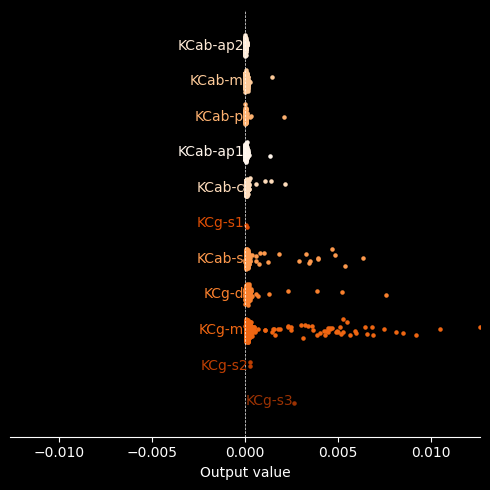



Investigating class DAN 

Cell type PPL1-α′2α2 N= 2 mean= 3.465377260876128e-05
Cell type PAM-β′2m N= 31 mean= 4.034597413714912e-05
Cell type PAM-β2β′2a N= 10 mean= 4.6047764632552073e-05
Cell type PAM-β′2p N= 22 mean= 4.8908563340927624e-05
Cell type PPL107 N= 2 mean= 4.961262326523903e-05
Cell type PAM-β′1 ap N= 12 mean= 6.446452638646324e-05
Cell type PAM-β′1 m N= 16 mean= 7.094963561779774e-05
Cell type PPL1-α′3 N= 2 mean= 7.543571801182903e-05
Cell type PPL1-γ2α′1 N= 2 mean= 8.87837600649378e-05
Cell type PAM-β1 N= 13 mean= 8.889565255624886e-05
Cell type PAM-β′2a N= 13 mean= 0.00010351271120520898
Cell type PAM-γ4<γ1γ2 N= 18 mean= 0.00010724756806111215
Cell type CB2730 N= 3 mean= 0.00011890970222572311
Cell type PPL108 N= 2 mean= 0.00012398372889145
Cell type PAM-β1ped N= 11 mean= 0.00013122758421974112
Cell type PPL1-α3 N= 2 mean= 0.00014461960685340002
Cell type PAM-γ3 N= 23 mean= 0.00015123026048060898
Cell type PAM-γ4 N= 46 mean= 0.00015651656809960096
Cell type PAM15 N= 

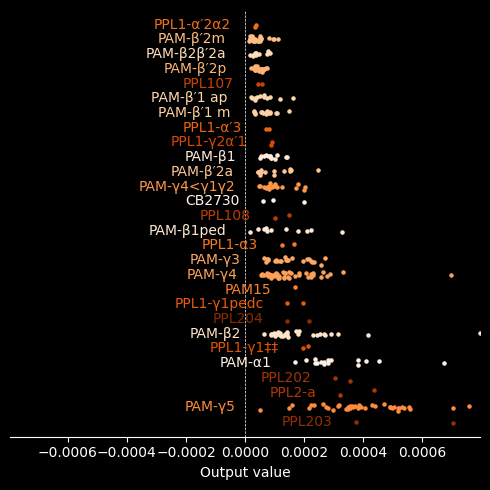



Investigating class MBON 

Cell type MBON-β′2mp N= 2 mean= 1.228832598281994e-05
Cell type MBON-α′2 N= 2 mean= 1.851635911549621e-05
Cell type MBON-α1 N= 4 mean= 4.5590789567467426e-05
Cell type MBON-β1>α N= 2 mean= 4.660386064985767e-05
Cell type MBON-α′3ap N= 2 mean= 4.793923155749555e-05
Cell type MBON-γ2α′1 N= 4 mean= 5.036925991118877e-05
Cell type MBON-β′2mp bilateral N= 2 mean= 5.2869547322834825e-05
Cell type MBON-calyx N= 2 mean= 5.9899000997591824e-05
Cell type MBON-β2β′2a N= 2 mean= 6.24627311080002e-05
Cell type MBON-α′1a N= 2 mean= 6.290707967535747e-05
Cell type MBON-α2sp N= 2 mean= 7.154039546142193e-05
Cell type MBON-γ3β′1 N= 4 mean= 7.269566543987395e-05
Cell type MBON-α2p3p N= 4 mean= 7.533779567950339e-05
Cell type MBON-β′1 N= 9 mean= 9.49955840952924e-05
Cell type MBON-α′3m N= 2 mean= 9.73433854570939e-05
Cell type MBON-γ1γ2γ3 N= 2 mean= 0.00010527201249011715
Cell type MBON-γ1pedc>α/β N= 2 mean= 0.00010808839498237439
Cell type MBON-β′2d N= 2 mean= 0.000108272736

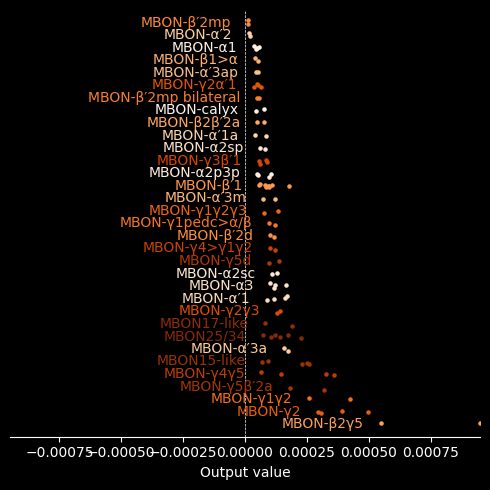



Investigating class LHCENT 

Cell type LHCENT14 N= 2 mean= 4.684182128435593e-05
Cell type LHCENT10 N= 4 mean= 0.000268961810848475
Cell type LHCENT5 N= 2 mean= 0.0002933868613966
Cell type LHCENT2 N= 2 mean= 0.00039796244667175
Cell type LHCENT8 N= 4 mean= 0.000405662909192575
Cell type LHCENT9 N= 2 mean= 0.00055641615214015
Cell type LHCENT4 N= 2 mean= 0.0005739103417039999
Cell type LHCENT1 N= 2 mean= 0.0006303558784244
Cell type LHCENT6 N= 2 mean= 0.00063646770387445
Cell type LHCENT13 N= 10 mean= 0.00065221092262897
Cell type LHCENT12 N= 6 mean= 0.0008007310999051
Cell type LHCENT3 N= 2 mean= 0.00085608497347655
Cell type LHCENT11 N= 2 mean= 0.00151668345908785


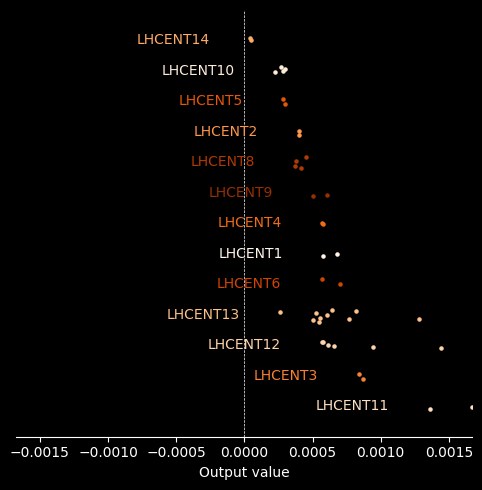

In [45]:
# investigate a single class in the form of cell types
for class_to_investigate in ['Kenyon_Cell', 'DAN', 'MBON', 'LHCENT']:
    print('\n\nInvestigating class', class_to_investigate, '\n')

    # get the neurons of the class from the max connectivity metrics
    class_neurons = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['root_id'].values
    class_values = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['max_connectivity'].values
    class_cell_types = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['cell_type'].values

    # get the unique cell types
    unique_cell_types = np.unique(class_cell_types)
    n_cell_types = len(unique_cell_types)

    cell_type_to_index = {c:i for i,c in enumerate(unique_cell_types)}
    index_to_cell_type = {i:c for i,c in enumerate(unique_cell_types)}

    # get the average connectivity for each cell type
    cell_type_values = np.zeros(n_cell_types)

    for i in range(n_cell_types):
        cell_type_values[i] = np.nanmean(np.abs(class_values[class_cell_types == unique_cell_types[i]]))
        
    # sort the cell types by average connectivity
    sorted_indices = np.argsort(cell_type_values)

    # scatter plot of the values
    plt.figure(figsize=(5,5))
    for i, idx in enumerate(sorted_indices):
        # get the values for the class
        cell_type_values = class_values[class_cell_types == unique_cell_types[idx]]
        print('Cell type', index_to_cell_type[idx], 'N=', len(cell_type_values), 'mean=', np.nanmean(np.abs(cell_type_values)))
        # plot the values
        plt.scatter(cell_type_values, -i + 0.1*np.random.randn(len(cell_type_values)), color=plt.cm.Oranges(idx/n_cell_types), s=5)
        # put the name of the class next to the points
        plt.text(np.nanmin(cell_type_values)-0.5*np.mean(np.abs(class_values)) if len(cell_type_values) > 0 else 0, -i, index_to_cell_type[idx], verticalalignment='center', horizontalalignment='right', fontsize=10, color=plt.cm.Oranges(idx/n_cell_types))
    # draw the zero line
    plt.axvline(0, color='white', linestyle='--', linewidth=0.5)
    max_value = np.max(np.abs(class_values))
    plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    plt.ylim(-n_cell_types, 1)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_{}_cell_types.pdf'.format(class_to_investigate)), bbox_inches='tight', dpi=300)
    plt.show()





Investigating class LHLN 

Cell type CB0311 N= 2 mean= 7.877622048358852e-05
Cell type LHAV2n1 N= 2 mean= 0.00010288122069420001
Cell type CB2749 N= 2 mean= 0.00011070645440957791
Cell type CB0279 N= 2 mean= 0.0001150146299563
Cell type LHPV4a10 N= 10 mean= 0.00011601255545987655
Cell type CB1058 N= 8 mean= 0.00011609980159525361
Cell type CB2790 N= 2 mean= 0.00011791187721074999
Cell type LHPV4a7b N= 2 mean= 0.0001192108137425
Cell type CB1160 N= 5 mean= 0.00012005632923243631
Cell type LHPD3a2 N= 5 mean= 0.0001247055742851991
Cell type CB2920 N= 5 mean= 0.00012691149775013303
Cell type LHAV4b2 N= 10 mean= 0.00012796022092751818
Cell type CB2554 N= 3 mean= 0.0001309543884998911
Cell type CB2677 N= 4 mean= 0.0001404124768234537
Cell type CB2914 N= 5 mean= 0.0001413110783797
Cell type CB2782 N= 2 mean= 0.0001438748692474
Cell type CB2463 N= 6 mean= 0.00014604961060095
Cell type CB3131 N= 2 mean= 0.00014747976578009998
Cell type CB1067 N= 4 mean= 0.0001488719635490297
Cell type CB1286 

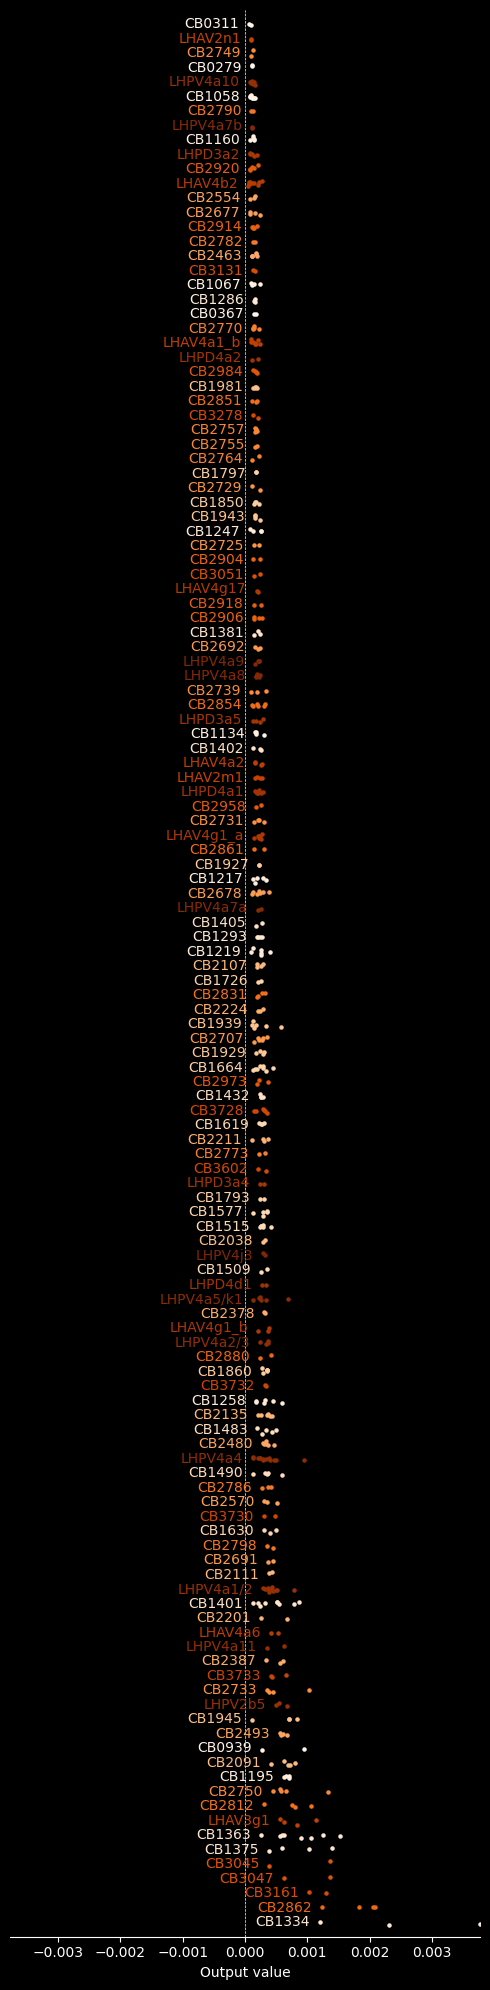

In [46]:
# investigate a single class in the form of cell types
for class_to_investigate in ['LHLN']:
    print('\n\nInvestigating class', class_to_investigate, '\n')

    # get the neurons of the class from the max connectivity metrics
    class_neurons = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['root_id'].values
    class_values = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['max_connectivity'].values
    class_cell_types = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['cell_type'].values

    # get the unique cell types
    unique_cell_types = np.unique(class_cell_types)
    n_cell_types = len(unique_cell_types)

    cell_type_to_index = {c:i for i,c in enumerate(unique_cell_types)}
    index_to_cell_type = {i:c for i,c in enumerate(unique_cell_types)}

    # get the average connectivity for each cell type
    cell_type_values = np.zeros(n_cell_types)

    for i in range(n_cell_types):
        cell_type_values[i] = np.nanmean(np.abs(class_values[class_cell_types == unique_cell_types[i]]))
        
    # sort the cell types by average connectivity
    sorted_indices = np.argsort(cell_type_values)

    # scatter plot of the values
    plt.figure(figsize=(5,20))
    for i, idx in enumerate(sorted_indices):
        # get the values for the class
        cell_type_values = class_values[class_cell_types == unique_cell_types[idx]]
        print('Cell type', index_to_cell_type[idx], 'N=', len(cell_type_values), 'mean=', np.nanmean(np.abs(cell_type_values)))
        # plot the values
        plt.scatter(cell_type_values, -i + 0.1*np.random.randn(len(cell_type_values)), color=plt.cm.Oranges(idx/n_cell_types), s=5)
        # put the name of the class next to the points
        plt.text(np.nanmin(cell_type_values)-0.5*np.mean(np.abs(class_values)) if len(cell_type_values) > 0 else 0, -i, index_to_cell_type[idx], verticalalignment='center', horizontalalignment='right', fontsize=10, color=plt.cm.Oranges(idx/n_cell_types))
    # draw the zero line
    plt.axvline(0, color='white', linestyle='--', linewidth=0.5)
    max_value = np.max(np.abs(class_values))
    plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    plt.ylim(-n_cell_types, 1)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_{}_cell_types.pdf'.format(class_to_investigate)), bbox_inches='tight', dpi=300)
    plt.show()





Investigating class FB 

Cell type FB3A N= 4 mean= 5.274943304722111e-06
Cell type FB7J N= 4 mean= 5.5402531698710175e-06
Cell type FB2B N= 7 mean= 8.02337774673054e-06
Cell type FB5S/6L N= 6 mean= 9.113364960060475e-06
Cell type FB9A/C N= 14 mean= 1.1962218010283566e-05
Cell type FB4Z N= 16 mean= 1.2096354369034626e-05
Cell type FB4Z/5U/5R N= 12 mean= 1.2106026310444963e-05
Cell type FB4Q_b N= 4 mean= 1.2259791261663446e-05
Cell type FB4B N= 2 mean= 1.2383907049400489e-05
Cell type FB5A N= 4 mean= 1.3165962542070798e-05
Cell type FB7E N= 5 mean= 1.40945902765816e-05
Cell type FB8G N= 6 mean= 1.410707922548947e-05
Cell type FB6M N= 4 mean= 1.440443018696955e-05
Cell type FB4L N= 4 mean= 1.63589475196407e-05
Cell type FB9B N= 21 mean= 1.8154783743955808e-05
Cell type FB5Z N= 5 mean= 1.8616956775078075e-05
Cell type FB6O N= 2 mean= 1.8863714555462813e-05
Cell type FB4C N= 2 mean= 1.9023646177266734e-05
Cell type FB6H N= 2 mean= 1.907343183993117e-05
Cell type FB6R N= 4 mean= 1.92989378

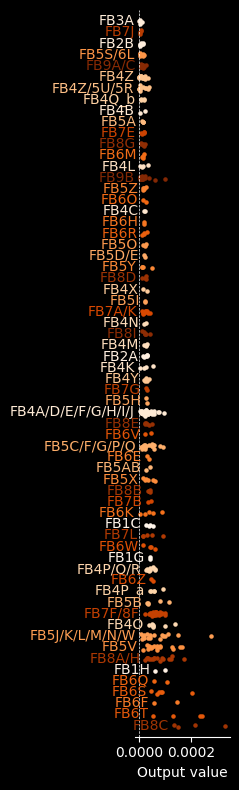



Investigating class CB.FB 

Cell type CB.FB7B0 N= 5 mean= 2.132166752618363e-06
Cell type CB.FB6B1 N= 8 mean= 3.818130942447887e-06
Cell type CB.FB3/4L1 N= 8 mean= 4.3359813025443786e-06
Cell type CB.FB3/4L0 N= 6 mean= 4.8007445202189785e-06
Cell type CB.FB5I0 N= 1 mean= 9.417942614861398e-06
Cell type CB.FB2I3 N= 5 mean= 1.0248201795769294e-05
Cell type CB.FB2E0 N= 4 mean= 1.0903807552647e-05
Cell type CB.FB2E8 N= 4 mean= 1.1084633743164393e-05
Cell type CB.FBTI0 N= 6 mean= 1.1360838507209143e-05
Cell type CB.FB6D0 N= 1 mean= 1.1846671970093804e-05
Cell type CB.FB2E10 N= 4 mean= 1.219380758162215e-05
Cell type CB.FB2I2 N= 6 mean= 1.2549837183009513e-05
Cell type CB.FB2E3 N= 6 mean= 1.26204060575206e-05
Cell type CB.FB2E9 N= 4 mean= 1.2754582061168314e-05
Cell type CB.FB1I1 N= 9 mean= 1.388517291100606e-05
Cell type CB.FB2I1 N= 6 mean= 1.3900190118692576e-05
Cell type CB.FB6I0 N= 4 mean= 1.510410490968699e-05
Cell type CB.FB7D0 N= 10 mean= 1.5868084044998748e-05
Cell type CB.FB5I1 N=

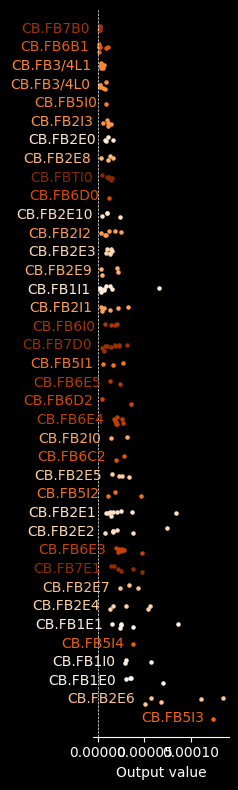



Investigating class FC/FS/hDelta/vDelta/FR 

Cell type FC1A/B/F N= 43 mean= 3.311156453931504e-06
Cell type FC1D/E N= 38 mean= 3.7037147320878355e-06
Cell type FS2 N= 38 mean= 4.078127420454892e-06
Cell type hDeltaL N= 12 mean= 4.306076941899542e-06
Cell type FC2A N= 16 mean= 5.014276721026383e-06
Cell type FR1 N= 18 mean= 5.034245684655166e-06
Cell type hDeltaF N= 8 mean= 5.130753058134916e-06
Cell type FC1C N= 27 mean= 5.409506866271251e-06
Cell type hDeltaI N= 20 mean= 5.898736159368065e-06
Cell type FC2B N= 28 mean= 5.9242107244146086e-06
Cell type hDeltaG N= 8 mean= 6.684342504561067e-06
Cell type FC2C N= 40 mean= 6.848245948562498e-06
Cell type hDeltaE N= 8 mean= 7.6117823922081865e-06
Cell type FS1A/B N= 64 mean= 8.171268631269532e-06
Cell type hDeltaA N= 10 mean= 8.360109949281844e-06
Cell type hDeltaK N= 31 mean= 9.870216532966943e-06
Cell type vDeltaA/B/C/D/E/J/K/L/M N= 315 mean= 1.0927989044731689e-05
Cell type FS3 N= 68 mean= 1.1357181657395747e-05
Cell type hDeltaB N= 18

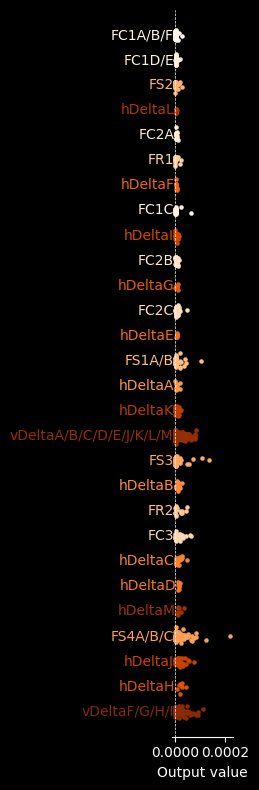

In [47]:
# investigate a single cell type that starts with 'FB' or 'CB
for class_to_investigate in ['FB','CB.FB','FC/FS/hDelta/vDelta/FR']:
    print('\n\nInvestigating class', class_to_investigate, '\n')

    # mask by cell type
    filter_labels = class_to_investigate.split('/')
    masks = [max_connectivity_metrics['cell_type'].str.startswith(f) for f in filter_labels]
    mask = np.logical_or.reduce(masks)
    # set nans to False
    mask[max_connectivity_metrics['cell_type'].isna()] = False


    # get the neurons of the class from the max connectivity metrics
    class_neurons = max_connectivity_metrics[mask]['root_id'].values
    class_values = max_connectivity_metrics[mask]['max_connectivity'].values
    class_cell_types = max_connectivity_metrics[mask]['cell_type'].values

    # get the unique cell types
    unique_cell_types = np.unique(class_cell_types)
    n_cell_types = len(unique_cell_types)

    cell_type_to_index = {c:i for i,c in enumerate(unique_cell_types)}
    index_to_cell_type = {i:c for i,c in enumerate(unique_cell_types)}

    # get the average connectivity for each cell type
    cell_type_values = np.zeros(n_cell_types)

    for i in range(n_cell_types):
        cell_type_values[i] = np.nanmean(np.abs(class_values[class_cell_types == unique_cell_types[i]]))
        
    # sort the cell types by average connectivity
    sorted_indices = np.argsort(cell_type_values)

    # scatter plot of the values
    plt.figure(figsize=(2.5,8))
    for i, idx in enumerate(sorted_indices):
        # get the values for the class
        cell_type_values = class_values[class_cell_types == unique_cell_types[idx]]
        print('Cell type', index_to_cell_type[idx], 'N=', len(cell_type_values), 'mean=', np.nanmean(np.abs(cell_type_values)))
        # plot the values
        plt.scatter(cell_type_values, -i + 0.1*np.random.randn(len(cell_type_values)), color=plt.cm.Oranges(idx/n_cell_types), s=5)
        # put the name of the class next to the points
        plt.text(np.nanmin(cell_type_values)-0.5*np.mean(np.abs(class_values)) if len(cell_type_values) > 0 else 0, -i, index_to_cell_type[idx], verticalalignment='center', horizontalalignment='right', fontsize=10, color=plt.cm.Oranges(idx/n_cell_types))
    # draw the zero line
    plt.axvline(0, color='white', linestyle='--', linewidth=0.5)
    # max_value = np.max(np.abs(class_values))
    # plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    plt.ylim(-n_cell_types, 1)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_{}_cell_types.pdf'.format(class_to_investigate.replace('/','-'))), bbox_inches='tight', dpi=300)
    plt.show()





Investigating class CX 

Cell type PFNa N= 55 mean= 2.106248723379339e-06
Cell type EPGt N= 4 mean= 2.846402206111897e-06
Cell type LNOa N= 2 mean= 3.1350235225652954e-06
Cell type P1-9 N= 2 mean= 3.3817063695383257e-06
Cell type EL N= 17 mean= 3.507643997348507e-06
Cell type PEN_b(PEN2) N= 22 mean= 4.356403522629331e-06
Cell type PEG N= 20 mean= 4.3793999784130265e-06
Cell type PFL1 N= 14 mean= 5.067378449226077e-06
Cell type P6-8P9 N= 4 mean= 5.262500292377187e-06
Cell type PFL3 N= 24 mean= 5.856053823783487e-06
Cell type Delta7 N= 40 mean= 7.525114150940638e-06
Cell type IbSpsP N= 30 mean= 7.73839361325921e-06
Cell type PFNd N= 40 mean= 7.897553453945135e-06
Cell type PFR N= 30 mean= 8.882787673533676e-06
Cell type PFL2 N= 12 mean= 1.0027929559068785e-05
Cell type PEN_a(PEN1) N= 20 mean= 1.042343463180348e-05
Cell type PFNm/p N= 321 mean= 1.0549899114644916e-05
Cell type EPG N= 47 mean= 1.2695717814974831e-05
Cell type PFGs N= 24 mean= 1.4813791322127318e-05
Cell type LNO1 N= 4 me

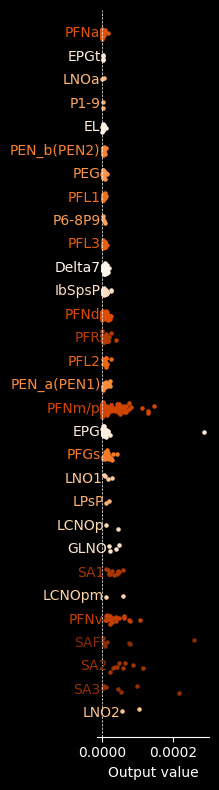

In [48]:
# investigate a single cell type that starts with 'FB' or 'CB
cell_types_to_exclude = ['FB','CB.FB','ER','ExR','FC','FS','FR','hDelta','vDelta']
for class_to_investigate in ['CX']:
    print('\n\nInvestigating class', class_to_investigate, '\n')

    # mask by cell type
    filter_labels = cell_types_to_exclude
    masks = [max_connectivity_metrics['cell_type'].str.startswith(f) for f in filter_labels]
    exclude_mask = np.logical_or.reduce(masks)
    # set nans to False
    exclude_mask[max_connectivity_metrics['cell_type'].isna()] = False
    # remove the excluded cell types
    exclude_mask = np.logical_not(exclude_mask)

    cleaned_connectivity = max_connectivity_metrics[exclude_mask]
    # get the neurons of the class from the max connectivity metrics
    class_neurons = cleaned_connectivity[cleaned_connectivity['class'] == class_to_investigate]['root_id'].values
    class_values = cleaned_connectivity[cleaned_connectivity['class'] == class_to_investigate]['max_connectivity'].values
    class_cell_types = cleaned_connectivity[cleaned_connectivity['class'] == class_to_investigate]['cell_type'].values
    # turn class_cell_types into a list of strings
    class_cell_types = np.array([str(x) for x in class_cell_types])

    # remove nan cell types
    remove_mask = class_cell_types == 'nan'
    class_cell_types = class_cell_types[np.logical_not(remove_mask)]
    class_values = class_values[np.logical_not(remove_mask)]
    class_neurons = class_neurons[np.logical_not(remove_mask)]


    # get the unique cell types
    unique_cell_types = np.unique(class_cell_types)
    n_cell_types = len(unique_cell_types)

    cell_type_to_index = {c:i for i,c in enumerate(unique_cell_types)}
    index_to_cell_type = {i:c for i,c in enumerate(unique_cell_types)}

    # get the average connectivity for each cell type
    cell_type_values = np.zeros(n_cell_types)

    for i in range(n_cell_types):
        cell_type_values[i] = np.nanmean(np.abs(class_values[class_cell_types == unique_cell_types[i]]))
        
    # sort the cell types by average connectivity
    sorted_indices = np.argsort(cell_type_values)

    # scatter plot of the values
    plt.figure(figsize=(2.5,8))
    for i, idx in enumerate(sorted_indices):
        # get the values for the class
        cell_type_values = class_values[class_cell_types == unique_cell_types[idx]]
        print('Cell type', index_to_cell_type[idx], 'N=', len(cell_type_values), 'mean=', np.nanmean(np.abs(cell_type_values)))
        # plot the values
        plt.scatter(cell_type_values, -i + 0.1*np.random.randn(len(cell_type_values)), color=plt.cm.Oranges(idx/n_cell_types), s=5)
        # put the name of the class next to the points
        plt.text(np.nanmin(cell_type_values)-0.5*np.mean(np.abs(class_values)) if len(cell_type_values) > 0 else 0, -i, index_to_cell_type[idx], verticalalignment='center', horizontalalignment='right', fontsize=10, color=plt.cm.Oranges(idx/n_cell_types))
    # draw the zero line
    plt.axvline(0, color='white', linestyle='--', linewidth=0.5)
    # max_value = np.max(np.abs(class_values))
    # plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    plt.ylim(-n_cell_types, 1)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_{}_cell_types.pdf'.format(class_to_investigate)), bbox_inches='tight', dpi=300)
    plt.show()





Investigating class other descending 



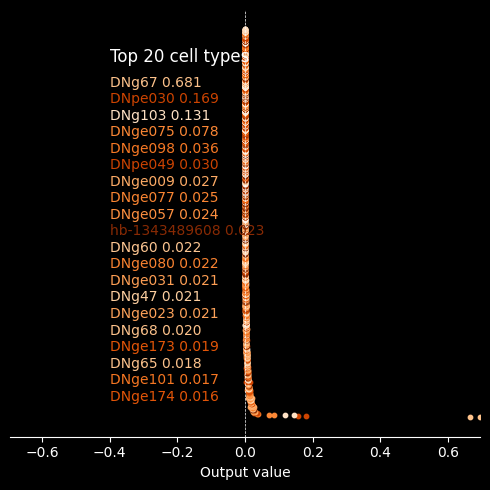

In [ ]:
for class_to_investigate in ['other descending']:
    print('\n\nInvestigating class', class_to_investigate, '\n')

    # get the neurons of the class from the max connectivity metrics
    class_neurons = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['root_id'].values
    class_values = max_connectivity_metrics[max_connectivity_metrics['class'] == class_to_investigate]['max_connectivity'].values

    # get the cell types of the class
    class_cell_types = np.array([get_cell_type(n) for n in class_neurons])

    # get the unique cell types
    unique_cell_types = np.unique(class_cell_types)
    n_cell_types = len(unique_cell_types)

    cell_type_to_index = {c:i for i,c in enumerate(unique_cell_types)}
    index_to_cell_type = {i:c for i,c in enumerate(unique_cell_types)}

    # get the average connectivity for each cell type
    cell_type_values = np.zeros(n_cell_types)

    for i in range(n_cell_types):
        cell_type_values[i] = np.nanmean(np.abs(class_values[class_cell_types == unique_cell_types[i]]))
        
    # sort the cell types by average connectivity
    sorted_indices = np.argsort(cell_type_values)[::-1]

    # scatter plot of the values
    plt.figure(figsize=(5,5))
    plt.text(-0.4, 430, 'Top 20 cell types', fontsize=12, color='white')
    for i, idx in enumerate(sorted_indices):
        # get the values for the class
        cell_type_values = class_values[class_cell_types == unique_cell_types[idx]]
        # text = 'Cell type' + index_to_cell_type[idx] +  'N=' +  len(cell_type_values) +  'mean=' +  np.nanmean(np.abs(cell_type_values))
        if i < 20:
            text = f'{index_to_cell_type[idx]} {np.nanmean(np.abs(cell_type_values)):.3f}'
            plt.text(-0.4, 400 - 20*i, text, fontsize=10, color=plt.cm.Oranges(idx/n_cell_types))
        # plot the values
        plt.scatter(cell_type_values, i + 0.1*np.random.randn(len(cell_type_values)), color=plt.cm.Oranges(idx/n_cell_types), s=10)
    # draw the zero line
    plt.axvline(0, color='white', linestyle='--', linewidth=0.5)
    max_value = np.max(np.abs(class_values))
    plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    # plt.ylim(-n_cell_types, 1)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_max_connectivity_{}_cell_types.pdf'.format(class_to_investigate)), bbox_inches='tight', dpi=300)
    plt.show()



In [22]:
recalculate = False

In [23]:
# add an absolute connectivity column
max_connectivity_metrics['abs_max_connectivity'] = np.abs(max_connectivity_metrics['max_connectivity'])

In [24]:
# get all MBONs and their max connectivity
MBONs = max_connectivity_metrics[max_connectivity_metrics['class'] == 'MBON']
# get average max connectivity for each cell type
MBONs_by_cell_type = MBONs.groupby('cell_type')['abs_max_connectivity'].mean().reset_index()
# sort by max connectivity
MBONs_by_cell_type = MBONs_by_cell_type.sort_values('abs_max_connectivity', ascending=True).reset_index(drop=True)
# sort the original dataframe by the order of the sorted cell types
MBONs_sorted = pd.DataFrame()
for cell_type in MBONs_by_cell_type['cell_type']:
    MBONs_sorted = pd.concat([MBONs_sorted, MBONs[MBONs['cell_type'] == cell_type]])


# get all DANs and their max connectivity
DANs = max_connectivity_metrics[max_connectivity_metrics['class'] == 'DAN']
# get average max connectivity for each cell type
DANs_by_cell_type = DANs.groupby('cell_type')['abs_max_connectivity'].mean().reset_index()
# sort by max connectivity
DANs_by_cell_type = DANs_by_cell_type.sort_values('abs_max_connectivity', ascending=True).reset_index(drop=True)
# sort the original dataframe by the order of the sorted cell types
DANs_sorted = pd.DataFrame()
for cell_type in DANs_by_cell_type['cell_type']:
    DANs_sorted = pd.concat([DANs_sorted, DANs[DANs['cell_type'] == cell_type]])

In [25]:

def create_connection_matrix(pre_neurons, post_neurons):
    # Filter the connections to only those that involve the specified pre and post neurons
    filtered_connections = connections[
        connections['pre_root_id'].isin(pre_neurons) & 
        connections['post_root_id'].isin(post_neurons)
    ]
    
    # Group by the neuron pair and sum the synapse counts
    grouped = filtered_connections.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    
    # Pivot the grouped data to form the connection matrix
    connection_matrix_df = grouped.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    
    # Ensure the matrix rows/columns align with pre_neurons and post_neurons
    connection_matrix_df = connection_matrix_df.reindex(index=pre_neurons, columns=post_neurons, fill_value=0)
    
    # Convert to a numpy array
    connection_matrix = connection_matrix_df.values
    return connection_matrix

matrix_file = os.path.join(processed_data_folder, 'GRN_connectivity/MBON_DAN_connection_matrix.npy')

if not os.path.exists(matrix_file) or recalculate:
    # Create a connection matrix for MBONs and DANs using the vectorized approach
    MBON_DAN_connection_matrix = create_connection_matrix(MBONs_sorted['root_id'].values, DANs_sorted['root_id'].values)
    np.save(matrix_file, MBON_DAN_connection_matrix)
else:
    MBON_DAN_connection_matrix = np.load(matrix_file)


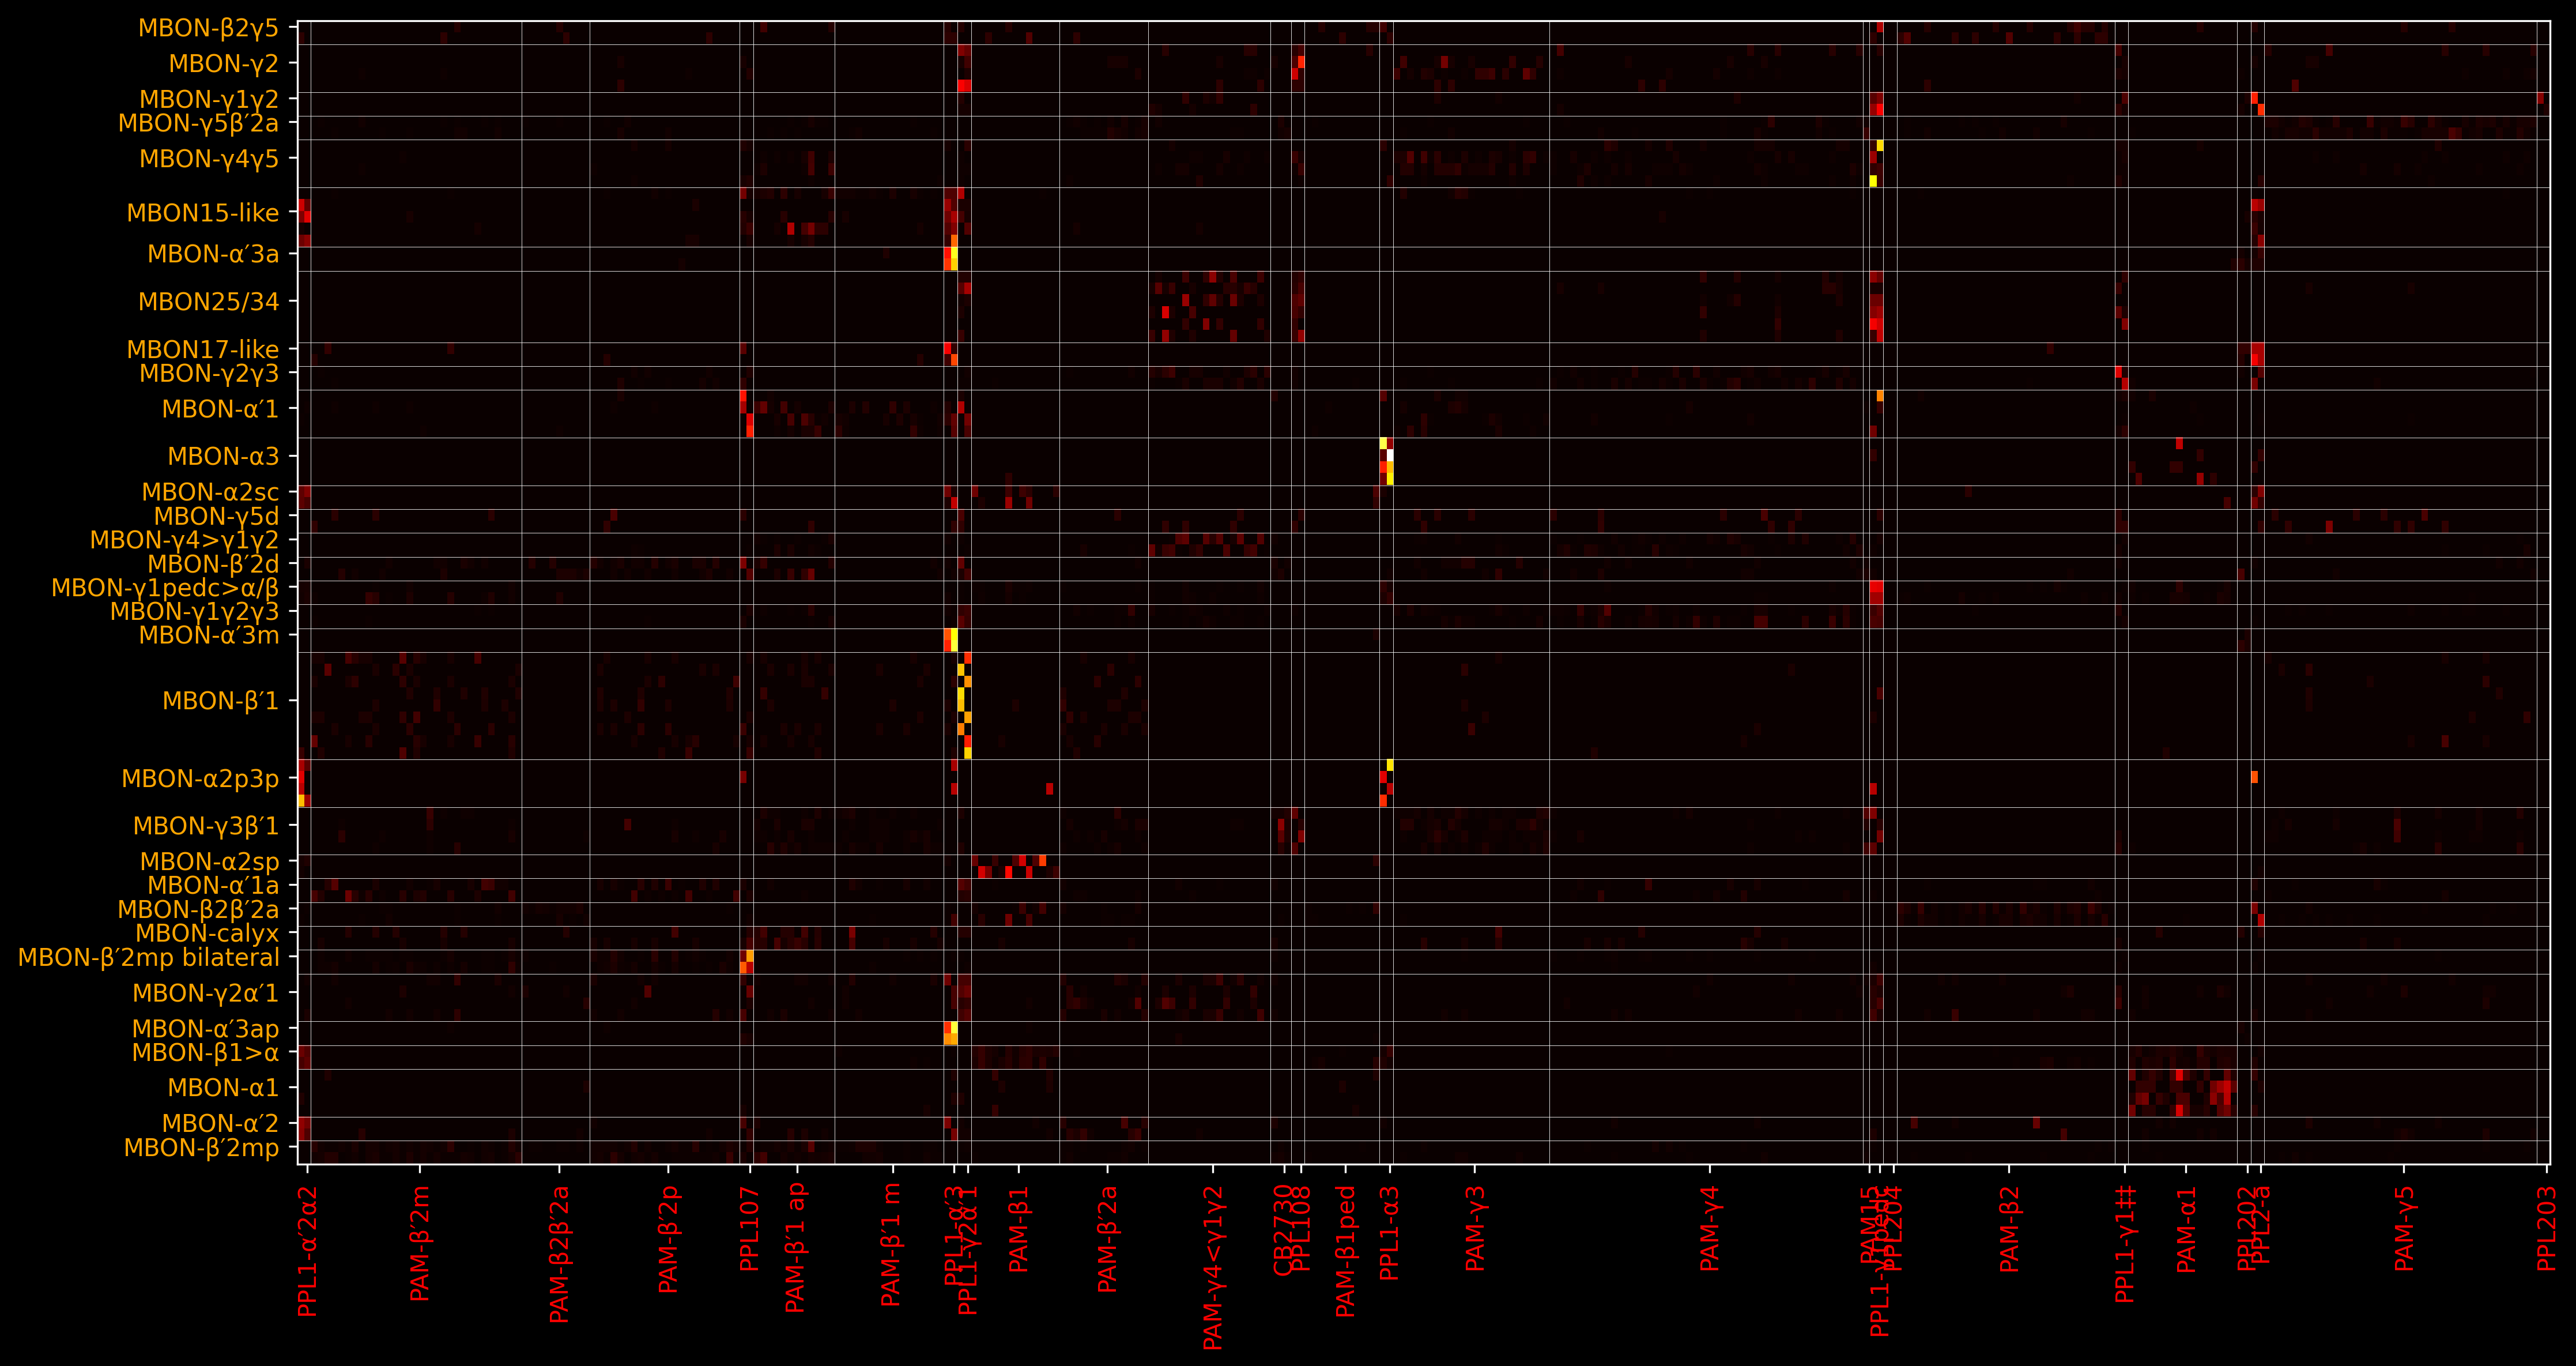

In [100]:
# normalize each row by the sum of the row
MBON_DAN_connection_matrix = MBON_DAN_connection_matrix / np.sum(MBON_DAN_connection_matrix, axis=1, keepdims=True)
MBON_DAN_connection_matrix = MBON_DAN_connection_matrix.T
MBON_cell_type_counts = MBONs_sorted.groupby('cell_type')['root_id'].count()[MBONs_by_cell_type['cell_type']].values
DAN_cell_type_counts = DANs_sorted.groupby('cell_type')['root_id'].count()[DANs_by_cell_type['cell_type']].values

# plot the connection matrix
plt.figure(figsize=(15,8), dpi=300)
plt.imshow(MBON_DAN_connection_matrix.T, cmap='hot', interpolation='nearest', aspect='auto')
# # draw the cell type boundaries
for i in np.cumsum(MBON_cell_type_counts):
    plt.axhline(i-0.5, color='white', linewidth=0.2)
for i in np.cumsum(DAN_cell_type_counts)[:-1]:
    plt.axvline(i-0.5, color='white', linewidth=0.2)
# put one of the cell types on the x axis
plt.xticks(np.cumsum(DAN_cell_type_counts)-DAN_cell_type_counts/2, DANs_by_cell_type['cell_type'], rotation=90, color='red')
# put one of the cell types on the y axis
plt.yticks(np.cumsum(MBON_cell_type_counts)-MBON_cell_type_counts/2, MBONs_by_cell_type['cell_type'], color='orange')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/MBON_DAN_connection_matrix.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [101]:
import numpy as np
import pandas as pd
import os

def create_second_order_connection_matrix(pre_neurons, post_neurons):
    # Filter connections for valid synapse strengths
    valid_connections = connections.copy()
    valid_connections = valid_connections[~np.isnan(valid_connections['syn_strength'])]
    valid_connections = valid_connections[(valid_connections['syn_strength'] > 0) & (valid_connections['syn_strength'] < 1)]
    
    # Determine downstream neurons from pre_neurons and upstream neurons to post_neurons
    downstream_connections = valid_connections[valid_connections['pre_root_id'].isin(pre_neurons)]
    downstream_neurons = downstream_connections['post_root_id'].unique()
    
    upstream_connections = valid_connections[valid_connections['post_root_id'].isin(post_neurons)]
    upstream_neurons = upstream_connections['pre_root_id'].unique()
    
    # The common intermediate neurons are the intersection of downstream and upstream neurons
    common_neurons = np.intersect1d(downstream_neurons, upstream_neurons)
    
    # Build pre->common matrix using groupby and pivot:
    pre_common_connections = connections[
        (connections['pre_root_id'].isin(pre_neurons)) &
        (connections['post_root_id'].isin(common_neurons))
    ]
    pre_common_group = pre_common_connections.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    pre_common_matrix_df = pre_common_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    # Ensure the matrix rows/columns align with pre_neurons and common_neurons
    pre_common_matrix_df = pre_common_matrix_df.reindex(index=pre_neurons, columns=common_neurons, fill_value=0)
    pre_common_matrix = pre_common_matrix_df.values

    # Build common->post matrix:
    common_post_connections = connections[
        (connections['pre_root_id'].isin(common_neurons)) &
        (connections['post_root_id'].isin(post_neurons))
    ]
    common_post_group = common_post_connections.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    common_post_matrix_df = common_post_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    common_post_matrix_df = common_post_matrix_df.reindex(index=common_neurons, columns=post_neurons, fill_value=0)
    common_post_matrix = common_post_matrix_df.values

    # Multiply the matrices to obtain the second order connection matrix and take the square root (geometric mean)
    second_order_connection_matrix = np.dot(pre_common_matrix, common_post_matrix)
    second_order_connection_matrix = np.sqrt(second_order_connection_matrix)
    
    return second_order_connection_matrix, common_neurons

# Example usage:
processed_matrix_file = os.path.join(processed_data_folder, 'GRN_connectivity/MBON_DAN_second_order_connection_matrix.npy')
processed_common_file = os.path.join(processed_data_folder, 'GRN_connectivity/MBON_DAN_common_neurons.npy')

if not os.path.exists(processed_matrix_file) or recalculate:
    MBON_DAN_second_order_connection_matrix, common_neurons = create_second_order_connection_matrix(
        MBONs_sorted['root_id'].values, DANs_sorted['root_id'].values
    )
    np.save(processed_matrix_file, MBON_DAN_second_order_connection_matrix)
    np.save(processed_common_file, common_neurons)
else:
    MBON_DAN_second_order_connection_matrix = np.load(processed_matrix_file)
    common_neurons = np.load(processed_common_file)


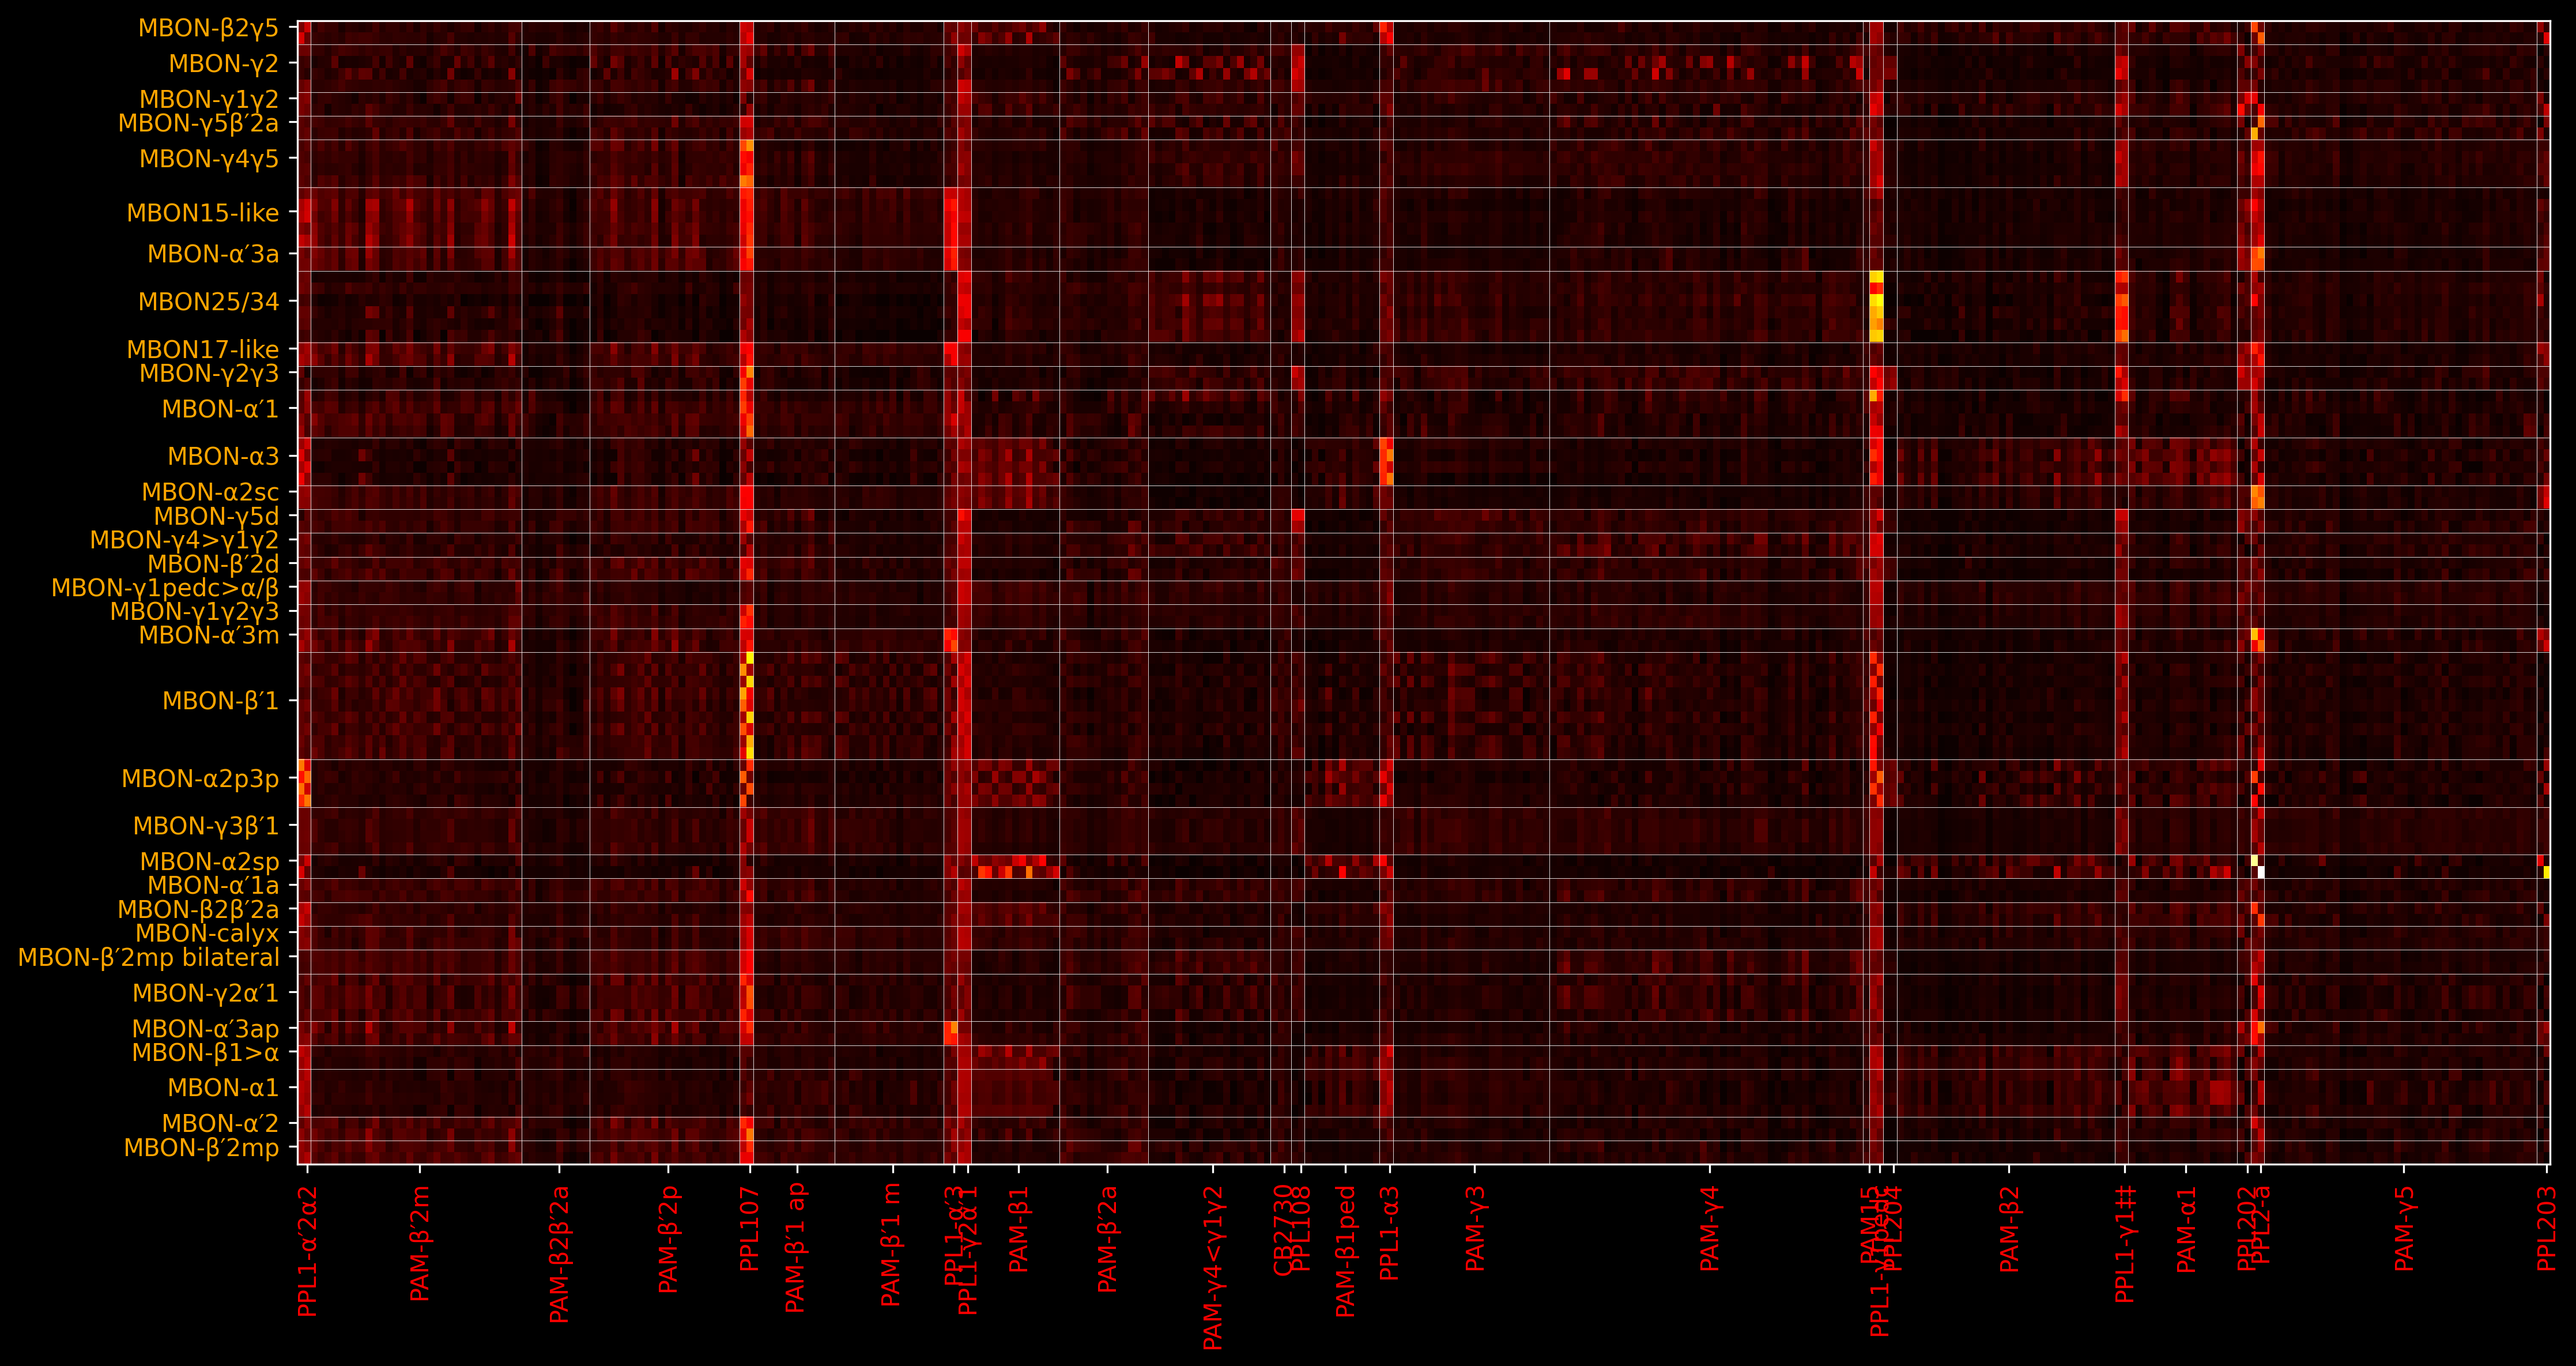

In [102]:
# normalize each row by the sum of the row
MBON_DAN_second_order_connection_matrix = MBON_DAN_second_order_connection_matrix / np.sum(MBON_DAN_second_order_connection_matrix, axis=1, keepdims=True)
MBON_DAN_second_order_connection_matrix = MBON_DAN_second_order_connection_matrix.T
MBON_cell_type_counts = MBONs_sorted.groupby('cell_type')['root_id'].count()[MBONs_by_cell_type['cell_type']].values
DAN_cell_type_counts = DANs_sorted.groupby('cell_type')['root_id'].count()[DANs_by_cell_type['cell_type']].values

# plot the connection matrix
plt.figure(figsize=(15,8), dpi=300)
plt.imshow(MBON_DAN_second_order_connection_matrix.T, cmap='hot', interpolation='nearest', aspect='auto')
# # draw the cell type boundaries
for i in np.cumsum(MBON_cell_type_counts):
    plt.axhline(i-0.5, color='white', linewidth=0.2)
for i in np.cumsum(DAN_cell_type_counts)[:-1]:
    plt.axvline(i-0.5, color='white', linewidth=0.2)
# put one of the cell types on the x axis
plt.xticks(np.cumsum(DAN_cell_type_counts)-DAN_cell_type_counts/2, DANs_by_cell_type['cell_type'], rotation=90, color='red')
# put one of the cell types on the y axis
plt.yticks(np.cumsum(MBON_cell_type_counts)-MBON_cell_type_counts/2, MBONs_by_cell_type['cell_type'], color='orange')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/MBON_DAN_second_order_connection_matrix.pdf'), bbox_inches='tight', dpi=300)
plt.show()

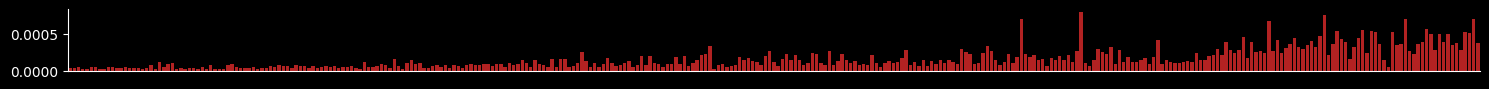

In [103]:
# create a plot for the connectivity of each cell type centered at the same points as the x and y ticks
plt.figure(figsize=(15,1))
plt.bar(np.arange(len(DANs_sorted)), DANs_sorted['abs_max_connectivity'], color='firebrick')
for spines in ['top', 'right']:
    plt.gca().spines[spines].set_visible(False)
plt.xlim(-0.5, len(DANs_sorted)-0.5)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/DAN_connectivity.pdf'), bbox_inches='tight', dpi=300)
plt.show()



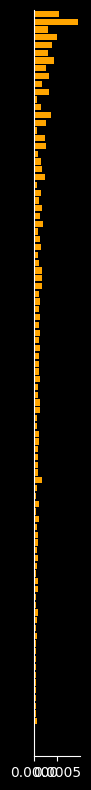

In [104]:
plt.figure(figsize=(1,8))
plt.barh(np.arange(len(MBONs_sorted)), MBONs_sorted['abs_max_connectivity'], color='orange')
for spines in ['top', 'right']:
    plt.gca().spines[spines].set_visible(False)
plt.ylim(-0.5, len(MBONs_sorted)-0.5)
plt.yticks([])
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/MBON_connectivity.pdf'), bbox_inches='tight', dpi=300)

In [373]:
# get DANs and MBONs with the highest max connectivity within their class

# get all MBONs and their max connectivity
MBONs = max_connectivity_metrics[max_connectivity_metrics['class'] == 'MBON']
# get average max connectivity for each cell type
MBONs_by_cell_type = MBONs.groupby('cell_type')['abs_max_connectivity'].mean().reset_index()
# get the top 25% of cell types by max connectivity
max_connectivity_upper_quartile = np.quantile(MBONs_by_cell_type['abs_max_connectivity'], 0.75)
MBONs_by_cell_type = MBONs_by_cell_type[MBONs_by_cell_type['abs_max_connectivity'] > max_connectivity_upper_quartile]
# sort by max connectivity
MBONs_by_cell_type = MBONs_by_cell_type.sort_values('abs_max_connectivity', ascending=True).reset_index(drop=True)
# sort the original dataframe by the order of the sorted cell types
MBONs_sorted = pd.DataFrame()
for cell_type in MBONs_by_cell_type['cell_type']:
    MBONs_sorted = pd.concat([MBONs_sorted, MBONs[MBONs['cell_type'] == cell_type]])

BEST_MBONs = MBONs_sorted.copy()

# get all DANs and their max connectivity
DANs = max_connectivity_metrics[max_connectivity_metrics['class'] == 'DAN']
# get average max connectivity for each cell type
DANs_by_cell_type = DANs.groupby('cell_type')['abs_max_connectivity'].mean().reset_index()
# get the top 25% of cell types by max connectivity
max_connectivity_upper_quartile = np.quantile(DANs_by_cell_type['abs_max_connectivity'], 0.75)
DANs_by_cell_type = DANs_by_cell_type[DANs_by_cell_type['abs_max_connectivity'] > max_connectivity_upper_quartile]
# sort by max connectivity
DANs_by_cell_type = DANs_by_cell_type.sort_values('abs_max_connectivity', ascending=True).reset_index(drop=True)
# sort the original dataframe by the order of the sorted cell types
DANs_sorted = pd.DataFrame()
for cell_type in DANs_by_cell_type['cell_type']:
    DANs_sorted = pd.concat([DANs_sorted, DANs[DANs['cell_type'] == cell_type]])

BEST_DANs = DANs_sorted.copy()


In [399]:
import networkx as nx

# For community detection using the Louvain algorithm
import community as community_louvain  
# For network embedding using node2vec
from node2vec import Node2Vec
# For visualization of the embedding use umap
from umap import UMAP

# ==============================================================================
# First Order Connectivity: Full Method
# ==============================================================================

def create_first_order_connection_matrix(pre_neurons, post_neurons):
    filtered_connections = connections[
        connections['pre_root_id'].isin(pre_neurons) & 
        connections['post_root_id'].isin(post_neurons)
    ]
    grouped = filtered_connections.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    connection_matrix_df = grouped.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    connection_matrix_df = connection_matrix_df.reindex(index=pre_neurons, columns=post_neurons, fill_value=0)
    return connection_matrix_df.values

# ==============================================================================
# Second Order Connectivity: Full Method via Intermediate Neurons
# ==============================================================================

def create_second_order_connection_matrix(pre_neurons, post_neurons):
    # Filter connections for valid synapse strengths
    valid_connections = connections.copy()
    valid_connections = valid_connections[~np.isnan(valid_connections['syn_strength'])]
    valid_connections = valid_connections[(valid_connections['syn_strength'] > 0) & (valid_connections['syn_strength'] < 1)]
    
    # Determine downstream (from pre_neurons) and upstream (to post_neurons) neurons
    downstream = valid_connections[valid_connections['pre_root_id'].isin(pre_neurons)]
    downstream_neurons = downstream['post_root_id'].unique()
    
    upstream = valid_connections[valid_connections['post_root_id'].isin(post_neurons)]
    upstream_neurons = upstream['pre_root_id'].unique()
    
    # Common intermediate neurons between the two groups
    common_neurons = np.intersect1d(downstream_neurons, upstream_neurons)

    # remove any neurons in common_neurons that are also in pre_neurons or post_neurons to prevent cycles
    common_neurons = common_neurons[~np.isin(common_neurons, np.concatenate([pre_neurons, post_neurons]))]
    
    # Build pre->common matrix
    pre_common_connections = connections[
        connections['pre_root_id'].isin(pre_neurons) & 
        connections['post_root_id'].isin(common_neurons)
    ]
    pre_common_group = pre_common_connections.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    pre_common_df = pre_common_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    pre_common_df = pre_common_df.reindex(index=pre_neurons, columns=common_neurons, fill_value=0)
    pre_common_matrix = pre_common_df.values

    # Build common->post matrix
    common_post_connections = connections[
        connections['pre_root_id'].isin(common_neurons) &
        connections['post_root_id'].isin(post_neurons)
    ]
    common_post_group = common_post_connections.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    common_post_df = common_post_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    common_post_df = common_post_df.reindex(index=common_neurons, columns=post_neurons, fill_value=0)
    common_post_matrix = common_post_df.values

    # Multiply the matrices to get second order connectivity and take geometric mean
    second_order = np.dot(pre_common_matrix, common_post_matrix)
    second_order = np.power(second_order, 1/2)
    return second_order, common_neurons


# ==============================================================================
# Third Order Connectivity: Full Method via Intermediate Neurons
# ==============================================================================

def create_third_order_connection_matrix(pre_neurons, post_neurons):
    """
    Compute a third order connection matrix between pre_neurons and post_neurons.
    Here a third order connection is defined as a path:
      pre_neuron -> intermediate1 -> intermediate2 -> post_neuron,
    where intermediate1 and intermediate2 are chosen by:
      - I1: all neurons downstream of pre_neurons
      - I2: all neurons upstream of post_neurons
    Only direct connections are considered at each step.
    
    The final third order connectivity is computed as the product of three matrices,
    with a cube root taken to (optionally) keep values in a comparable range.
    """
    # Filter valid connections based on synapse strength
    valid_connections = connections.copy()
    valid_connections = valid_connections[~np.isnan(valid_connections['syn_strength'])]
    valid_connections = valid_connections[(valid_connections['syn_strength'] > 0) & 
                                          (valid_connections['syn_strength'] < 1)]
    
    # Determine intermediate sets:
    # I1: neurons that appear as targets from pre_neurons
    pre_downstream = valid_connections[valid_connections['pre_root_id'].isin(pre_neurons)]
    I1 = np.unique(pre_downstream['post_root_id'])
    # remove any neurons in I1 that are also in pre_neurons or post_neurons to prevent cycles
    I1 = I1[~np.isin(I1, np.concatenate([pre_neurons, post_neurons]))]

    # I2: neurons that appear as sources to post_neurons
    post_upstream = valid_connections[valid_connections['post_root_id'].isin(post_neurons)]
    I2 = np.unique(post_upstream['pre_root_id'])
    # remove any neurons in I2 that are also in pre_neurons or post_neurons to prevent cycles
    I2 = I2[~np.isin(I2, np.concatenate([pre_neurons, post_neurons]))]

    # remove any neurons in I2 that are also in I1 to prevent cycles
    I2 = I2[~np.isin(I2, I1)] # I2: neurons that appear as sources to post_neurons

    
    # --- Build pre -> I1 matrix ---
    pre_I1 = valid_connections[
        valid_connections['pre_root_id'].isin(pre_neurons) &
        valid_connections['post_root_id'].isin(I1)
    ]
    pre_I1_group = pre_I1.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    pre_I1_df = pre_I1_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    pre_I1_df = pre_I1_df.reindex(index=pre_neurons, columns=I1, fill_value=0)
    pre_I1_matrix = pre_I1_df.values

    # --- Build I1 -> I2 matrix ---
    I1_I2 = valid_connections[
        valid_connections['pre_root_id'].isin(I1) &
        valid_connections['post_root_id'].isin(I2)
    ]
    I1_I2_group = I1_I2.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    I1_I2_df = I1_I2_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    I1_I2_df = I1_I2_df.reindex(index=I1, columns=I2, fill_value=0)
    I1_I2_matrix = I1_I2_df.values

    # --- Build I2 -> post matrix ---
    I2_post = valid_connections[
        valid_connections['pre_root_id'].isin(I2) &
        valid_connections['post_root_id'].isin(post_neurons)
    ]
    I2_post_group = I2_post.groupby(['pre_root_id', 'post_root_id'])['syn_count'].sum().reset_index()
    I2_post_df = I2_post_group.pivot(index='pre_root_id', columns='post_root_id', values='syn_count').fillna(0)
    I2_post_df = I2_post_df.reindex(index=I2, columns=post_neurons, fill_value=0)
    I2_post_matrix = I2_post_df.values

    # --- Multiply the three matrices ---
    third_order = np.dot(np.dot(pre_I1_matrix, I1_I2_matrix), I2_post_matrix)
    # Apply the cube root (geometric mean) to temper large values
    third_order = np.power(third_order, 1/3)
    
    return third_order, I1, I2

# ==============================================================================
# Reduction by Cell Type: Helper Function
# ==============================================================================

def reduce_by_cell_type(full_matrix, index_slices):
    """
    Given a full connectivity matrix (neurons x neurons) and a list of index arrays
    (one per cell type), average each block (i.e. connectivity between two cell types)
    to produce a reduced connectivity matrix.
    """
    num_types = len(index_slices)
    reduced = np.zeros((num_types, num_types))
    for i, inds_i in enumerate(index_slices):
        for j, inds_j in enumerate(index_slices):
            block = full_matrix[np.ix_(inds_i, inds_j)]
            reduced[i, j] = block.mean()
    return reduced

#################################################
# Helper Functions for Graph Construction
#################################################
def create_graph_from_matrix(connectivity_matrix, nodes, threshold=0):
    """
    Given a connectivity matrix (assumed to be neurons x neurons) and a list of node labels,
    create a directed graph. Only edges with weight > threshold are added.
    """
    G = nx.DiGraph()
    # Add nodes
    for node in nodes:
        G.add_node(node)
    # Add edges: iterate over the matrix
    num_nodes = len(nodes)
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = connectivity_matrix[i, j]
            if weight > threshold:
                G.add_edge(nodes[i], nodes[j], weight=weight)
    return G

#################################################
# Community Detection using Louvain Method
#################################################
def detect_communities(G):
    """
    Detect communities using the Louvain method. Note that Louvain works on undirected graphs,
    so we convert the directed graph to undirected.
    """
    if G.is_directed():
        UG = G.to_undirected()
    else:
        UG = G
    # Compute the best partition. 'weight' is used for weighted networks.
    partition = community_louvain.best_partition(UG, weight='weight')
    return partition

#################################################
# Network Embedding using Node2Vec
#################################################
def perform_node2vec_embedding(G, dimensions=64, walk_length=30, num_walks=200, p=1, q=1):
    """
    Compute node embeddings using the node2vec algorithm.
    Returns a dictionary mapping node -> embedding vector.
    """
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length,
                        num_walks=num_walks, p=p, q=q, weight_key='weight', workers=4)
    model = node2vec.fit(window=10, min_count=1)
    embeddings = {node: model.wv[node] for node in G.nodes()}
    return embeddings

#################################################
# Optional: Visualization Helpers
#################################################
def plot_communities(G, partition, pos=None, node_size=50):
    """
    Plot the network with nodes colored by community.
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    cmap = plt.cm.viridis
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_size,
                           cmap=cmap,
                           node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title("Community Detection (Louvain)")
    plt.show()

def plot_embedding(embeddings, partition, nodes, connectivity_matrix, threshold=0):
    """
    Reduce the high-dimensional embeddings to 2D using UMAP and plot them.
    """
    embedding_array = np.array([embeddings[node] for node in nodes])
    umap = UMAP(n_components=2, random_state=42)
    umap_embedding = umap.fit_transform(embedding_array)
    plt.figure(figsize=(8, 8))
    cmap = plt.cm.viridis
    plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=list(partition.values()), cmap=cmap, s=50, zorder=10)
    # label the nodes
    for i, node in enumerate(nodes):
        plt.text(umap_embedding[i, 0], umap_embedding[i, 1], node, fontsize=8)
    # Draw edges for connections above threshold
    for i in range(connectivity_matrix.shape[0]):
        for j in range(connectivity_matrix.shape[1]):
            if connectivity_matrix[i, j] > threshold:
                plt.plot([umap_embedding[i, 0], umap_embedding[j, 0]],
                         [umap_embedding[i, 1], umap_embedding[j, 1]], '-', color='lightgray', alpha=0.3, linewidth=connectivity_matrix[i, j]/np.max(connectivity_matrix))
    plt.title("Node Embeddings (UMAP)")
    plt.show()

In [400]:
recalculate = True

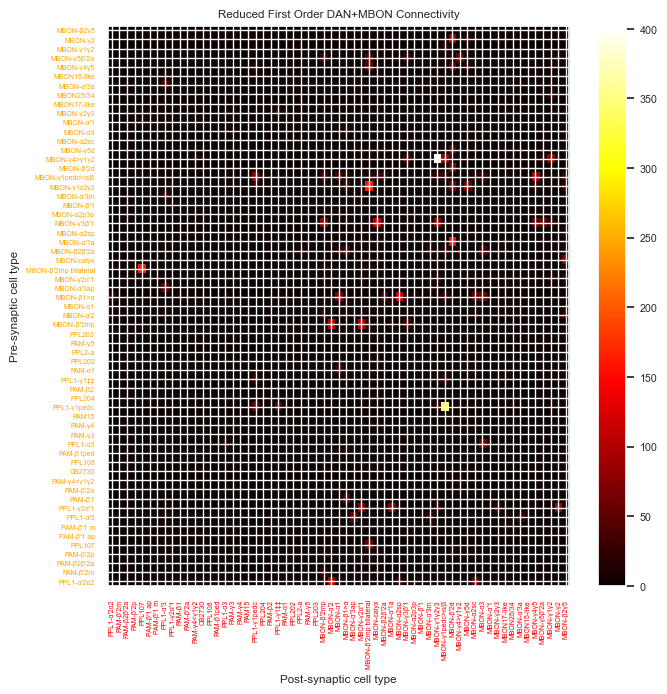

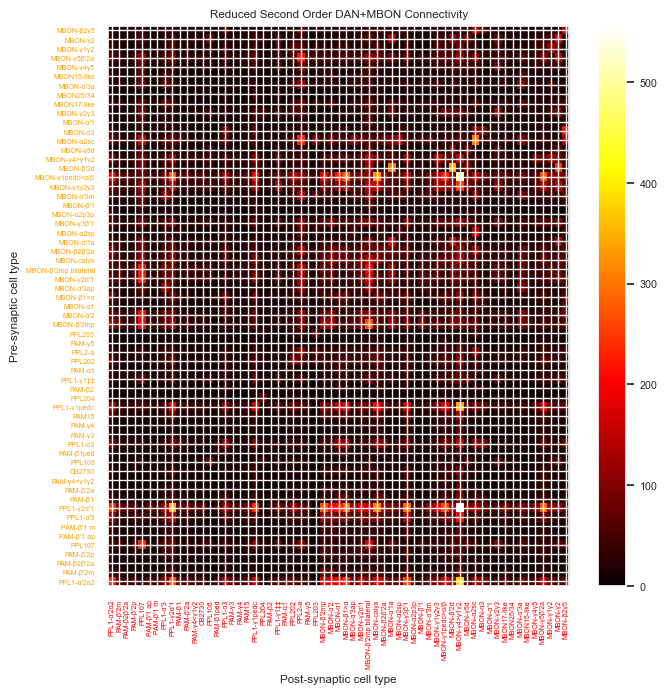

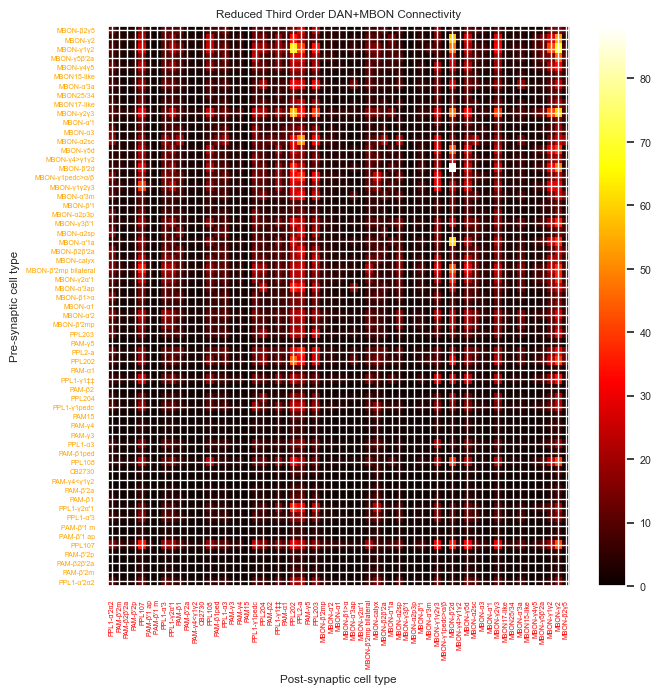

In [428]:
# perform a dan+mbon to dan+mbon analysis
# get all DANs and their max connectivity
DANs = max_connectivity_metrics[max_connectivity_metrics['class'] == 'DAN']
# get average max connectivity for each cell type
DANs_by_cell_type = DANs.groupby('cell_type')['abs_max_connectivity'].mean().reset_index()
# sort by max connectivity
DANs_by_cell_type = DANs_by_cell_type.sort_values('abs_max_connectivity', ascending=True).reset_index(drop=True)
# sort the original dataframe by the order of the sorted cell types
DANs_sorted = pd.DataFrame()
for cell_type in DANs_by_cell_type['cell_type']:
    DANs_sorted = pd.concat([DANs_sorted, DANs[DANs['cell_type'] == cell_type]])

# get all MBONs and their max connectivity
MBONs = max_connectivity_metrics[max_connectivity_metrics['class'] == 'MBON']
# get average max connectivity for each cell type
MBONs_by_cell_type = MBONs.groupby('cell_type')['abs_max_connectivity'].mean().reset_index()
# sort by max connectivity
MBONs_by_cell_type = MBONs_by_cell_type.sort_values('abs_max_connectivity', ascending=True).reset_index(drop=True)
# sort the original dataframe by the order of the sorted cell types
MBONs_sorted = pd.DataFrame()
for cell_type in MBONs_by_cell_type['cell_type']:
    MBONs_sorted = pd.concat([MBONs_sorted, MBONs[MBONs['cell_type'] == cell_type]])

# create the total list of neurons
neurons = np.concatenate([DANs_sorted['root_id'].values, MBONs_sorted['root_id'].values])
cell_types = np.concatenate([DANs_sorted['cell_type'].values, MBONs_sorted['cell_type'].values])

# create the first order connection matrix
matrix_file = os.path.join(processed_data_folder, 'GRN_connectivity/DAN+MBON_DAN+MBON_connection_matrix_first_order.npy')
if not os.path.exists(matrix_file) or recalculate:
    # Create a connection matrix for DANs and MBONs using the vectorized approach
    DAN_MBON_connection_matrix_first = create_first_order_connection_matrix(neurons, neurons)
    np.save(matrix_file, DAN_MBON_connection_matrix_first)
else:
    DAN_MBON_connection_matrix_first = np.load(matrix_file)

# create the second order connection matrix
matrix_file = os.path.join(processed_data_folder, 'GRN_connectivity/DAN+MBON_DAN+MBON_connection_matrix_second_order.npy')
if not os.path.exists(matrix_file) or recalculate:
    # Create a connection matrix for DANs and MBONs using the vectorized approach
    DAN_MBON_connection_matrix_second, common_neurons = create_second_order_connection_matrix(neurons, neurons)
    np.save(matrix_file, DAN_MBON_connection_matrix_second)
else:
    DAN_MBON_connection_matrix_second = np.load(matrix_file)

# create the third order connection matrix
matrix_file = os.path.join(processed_data_folder, 'GRN_connectivity/DAN+MBON_DAN+MBON_connection_matrix_third_order.npy')
if not os.path.exists(matrix_file) or recalculate:
    # Create a connection matrix for DANs and MBONs using the vectorized approach
    DAN_MBON_connection_matrix_third, I1, I2 = create_third_order_connection_matrix(neurons, neurons)
    np.save(matrix_file, DAN_MBON_connection_matrix_third)
else:
    DAN_MBON_connection_matrix_third = np.load(matrix_file)

# create the reduced connection matrix for all orders
DAN_cell_type_counts = DANs_sorted.groupby('cell_type')['root_id'].count()[DANs_by_cell_type['cell_type']].values
MBON_cell_type_counts = MBONs_sorted.groupby('cell_type')['root_id'].count()[MBONs_by_cell_type['cell_type']].values
index_slices = []
start = 0
for count in DAN_cell_type_counts:
    index_slices.append(np.arange(start, start + count))
    start += count
for count in MBON_cell_type_counts:
    index_slices.append(np.arange(start, start + count))
    start += count

reduced_first_order = reduce_by_cell_type(DAN_MBON_connection_matrix_first, index_slices)
reduced_second_order = reduce_by_cell_type(DAN_MBON_connection_matrix_second, index_slices)
reduced_third_order = reduce_by_cell_type(DAN_MBON_connection_matrix_third, index_slices)

reduced_cell_types = np.concatenate([DANs_by_cell_type['cell_type'], MBONs_by_cell_type['cell_type']])

# plot the reduced connection matrix
def plot_reduced_connection_matrix(reduced_matrix, cell_types, title):
    plt.figure(figsize=(7,7), dpi=100)
    plt.imshow(reduced_matrix, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(len(cell_types)), cell_types, rotation=90, color='red', fontsize=5)
    plt.yticks(np.arange(len(cell_types)), cell_types, color='orange', fontsize=5)
    plt.title(title)
    plt.xlabel("Post-synaptic cell type")
    plt.ylabel("Pre-synaptic cell type")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_reduced_connection_matrix(reduced_first_order, reduced_cell_types, "Reduced First Order DAN+MBON Connectivity")
plot_reduced_connection_matrix(reduced_second_order, reduced_cell_types, "Reduced Second Order DAN+MBON Connectivity")
plot_reduced_connection_matrix(reduced_third_order, reduced_cell_types, "Reduced Third Order DAN+MBON Connectivity")

In [440]:
def process_cmatrix(cmatrix):
    cmatrix = cmatrix.copy()
    # cmatrix = np.log(cmatrix)
    # cmatrix[cmatrix == -np.inf] = 0
    # cmatrix[cmatrix < 0] = 0
    return cmatrix

def plot_reduced_connection_matrix_with_annotations(cmatrix, cell_types):

    cmatrix = process_cmatrix(cmatrix)
    # create the dataframe
    df = pd.DataFrame(cmatrix, index=cell_types, columns=cell_types)

    # Create a clustermap with annotations
    sns.set(font_scale=0.5)
    clustermap = sns.clustermap(
        df, row_cluster=True, col_cluster=True, cbar_pos = (0.05, 0.1, 0.03, 0.4),
        cmap='hot', figsize=(10,10),

    )
    clustermap.ax_heatmap.set_xlabel("Post-synaptic cell type")
    clustermap.ax_heatmap.set_ylabel("Pre-synaptic cell type")

    for tick_label in clustermap.ax_heatmap.axes.get_yticklabels():
        # set color to orange if the label is in BEST_MBONs
        if tick_label.get_text() in BEST_MBONs['cell_type'].values:
            tick_label.set_color('orange')
        # set color to firebrick if the label is in BEST_DANs
        if tick_label.get_text() in BEST_DANs['cell_type'].values:
            tick_label.set_color('firebrick')
    for tick_label in clustermap.ax_heatmap.axes.get_xticklabels():
        # set color to orange if the label is in BEST_MBONs
        if tick_label.get_text() in BEST_MBONs['cell_type'].values:
            tick_label.set_color('orange')
        # set color to firebrick if the label is in BEST_DANs
        if tick_label.get_text() in BEST_DANs['cell_type'].values:
            tick_label.set_color('firebrick')

    plt.show()

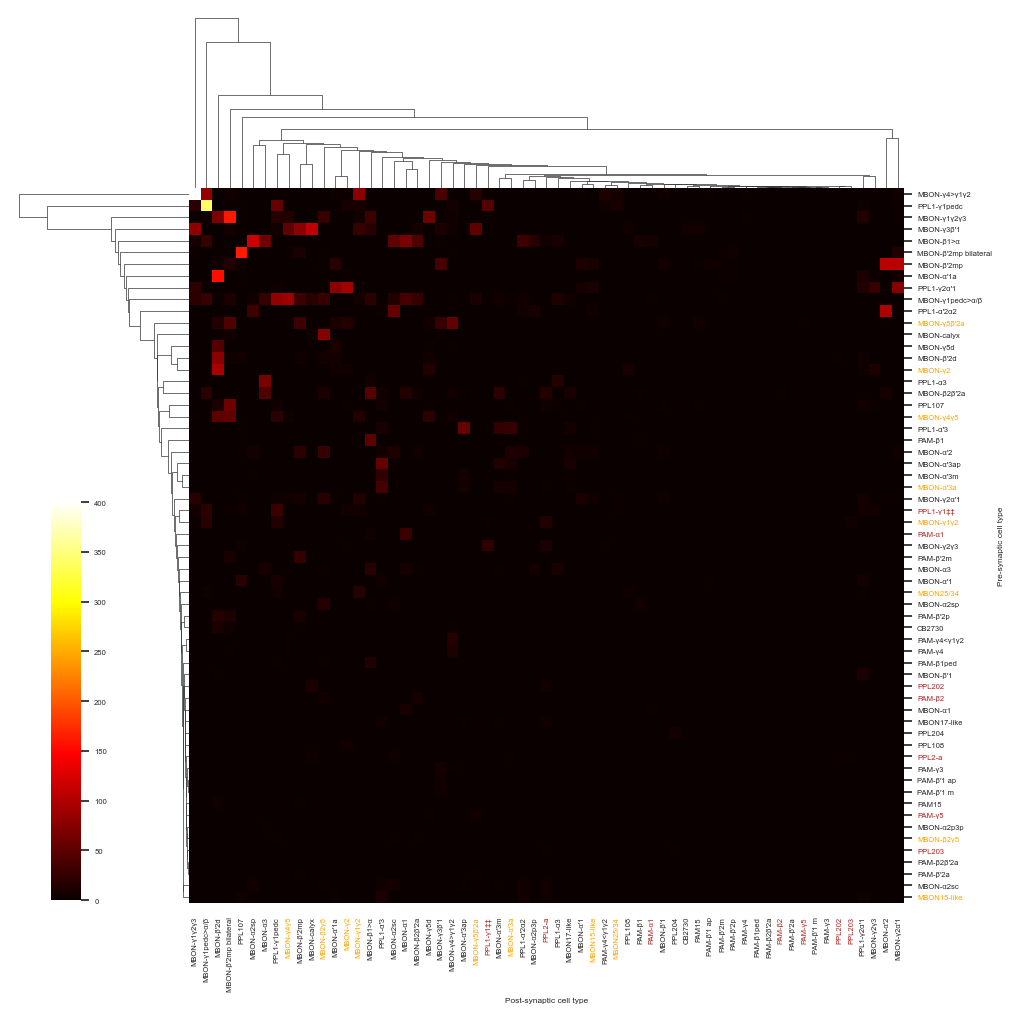

In [441]:
plot_reduced_connection_matrix_with_annotations(reduced_first_order, reduced_cell_types)

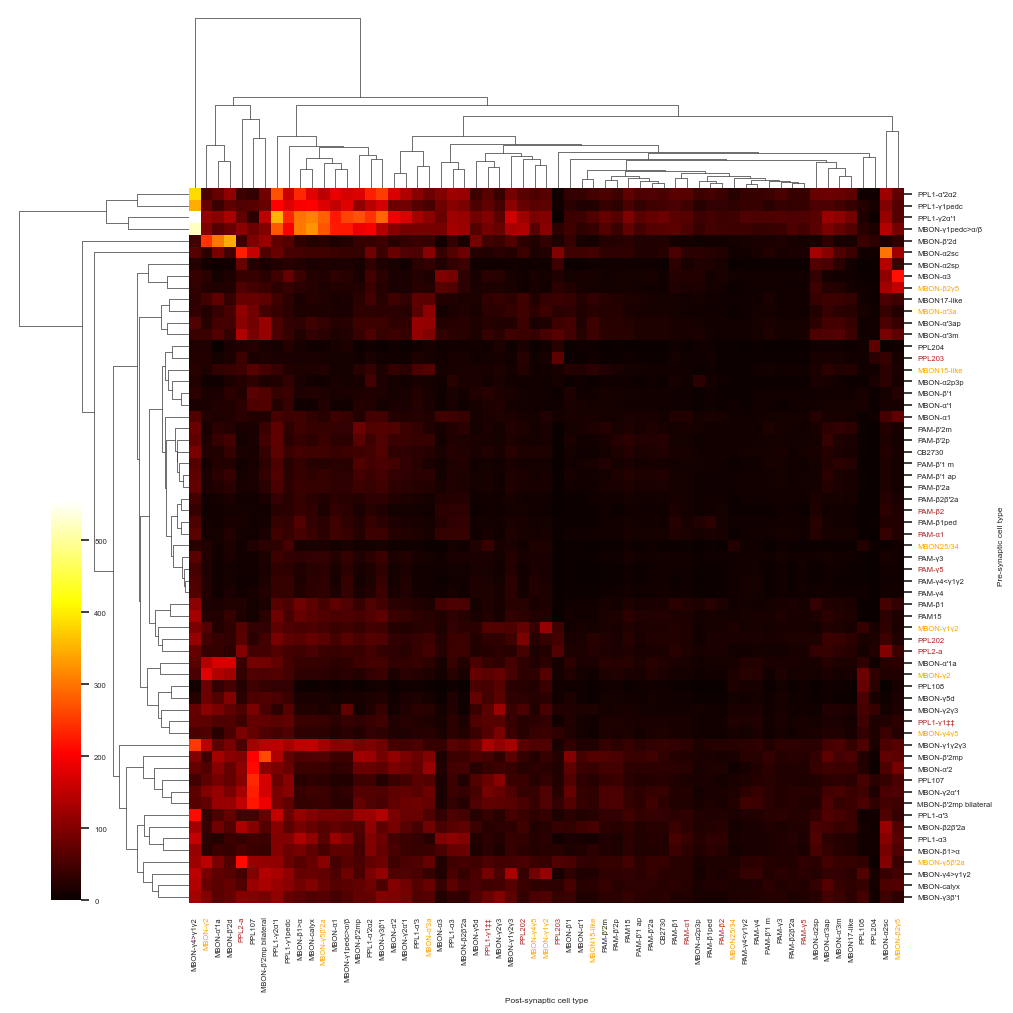

In [442]:
plot_reduced_connection_matrix_with_annotations(reduced_second_order, reduced_cell_types)

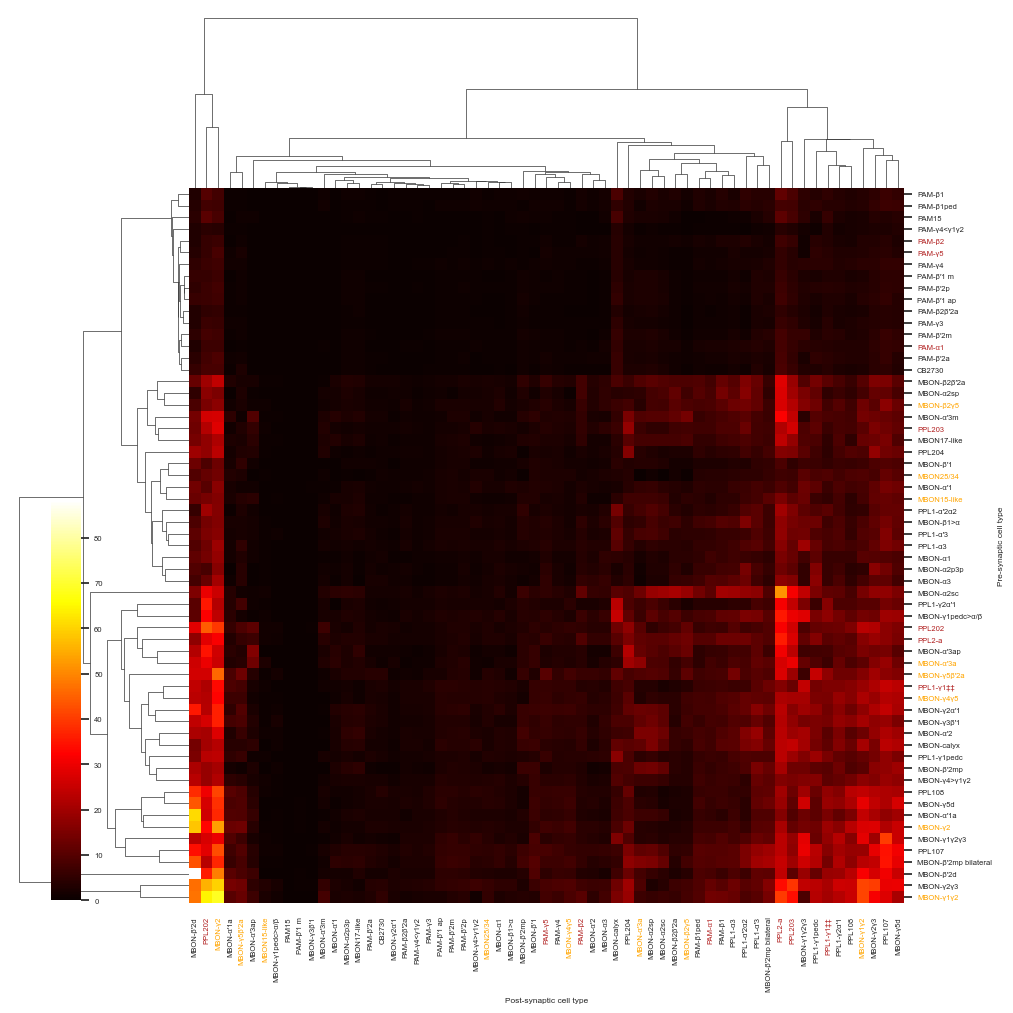

In [443]:
plot_reduced_connection_matrix_with_annotations(reduced_third_order, reduced_cell_types)

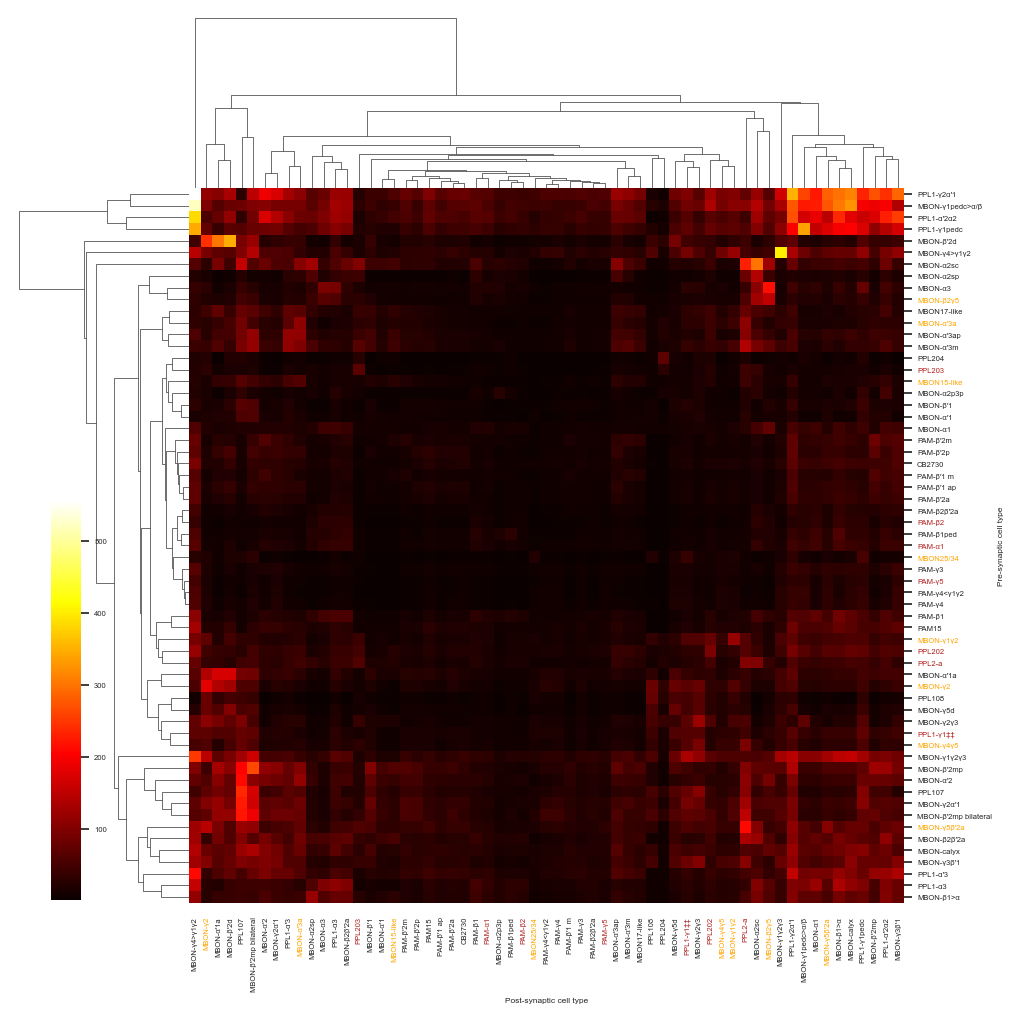

In [444]:
max_matrix = np.max([reduced_first_order, reduced_second_order, reduced_third_order], axis=0)
plot_reduced_connection_matrix_with_annotations(max_matrix, reduced_cell_types)

PAM-β2
PPL1-γ1‡‡
PAM-α1
PPL202
PPL2-a
PAM-γ5
PPL203
MBON25/34
MBON-α′3a
MBON15-like
MBON-γ4γ5
MBON-γ5β′2a
MBON-γ1γ2
MBON-γ2
MBON-β2γ5
PPL1-α′2α2
PAM-β′2m
PAM-β2β′2a
PAM-β′2p
PPL107
PAM-β′1 ap
PAM-β′1 m
PPL1-α′3
PPL1-γ2α′1
PAM-β1
PAM-β′2a
PAM-γ4<γ1γ2
CB2730
PPL108
PAM-β1ped
PPL1-α3
PAM-γ3
PAM-γ4
PAM15
PPL1-γ1pedc
PPL204
PAM-β2
PPL1-γ1‡‡
PAM-α1
PPL202
PPL2-a
PAM-γ5
PPL203


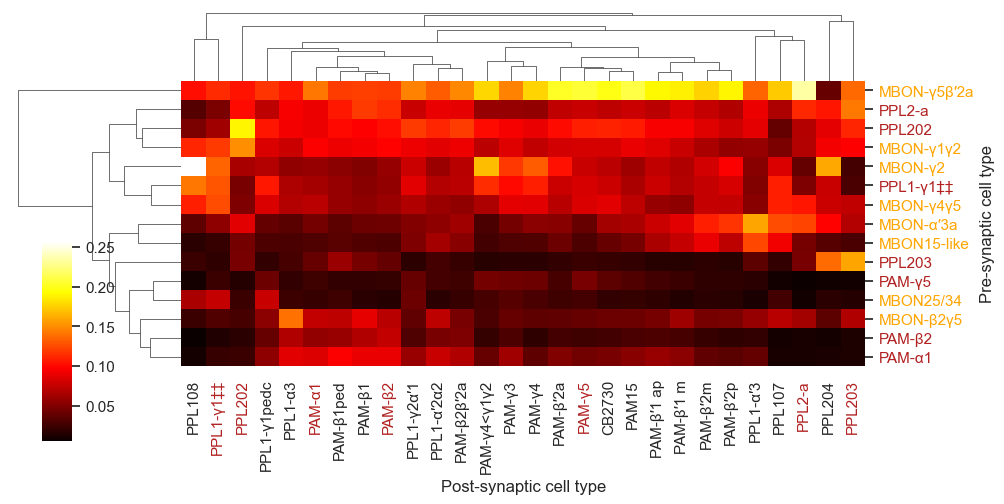

In [458]:
# keep only the best MBONs and DANs as presynaptic partners

# simplified max matrix
max_matrix = np.max([reduced_first_order, reduced_second_order, reduced_third_order], axis=0)
# create the mask for the presynaptic partners
mask_pre = []
for i in range(len(reduced_cell_types)):
    if reduced_cell_types[i] in BEST_MBONs['cell_type'].values or reduced_cell_types[i] in BEST_DANs['cell_type'].values:
        print(reduced_cell_types[i])
        mask_pre.append(True)
    else:
        mask_pre.append(False)
mask_pre = np.array(mask_pre)
# create the mask for the postsynaptic partners
mask_post = []
for i in range(len(reduced_cell_types)):
    if reduced_cell_types[i] in DANs_by_cell_type['cell_type'].values:
        print(reduced_cell_types[i])
        mask_post.append(True)
    else:
        mask_post.append(False)
mask_post = np.array(mask_post)
# apply the mask to the matrix
max_matrix = max_matrix[mask_pre][:, mask_post]
# apply the mask to the cell types
minimum_cell_types_pre = reduced_cell_types[mask_pre]
minimum_cell_types_post = reduced_cell_types[mask_post]

# normalize the matrix so that columns sum to 1
max_matrix = max_matrix / np.sum(max_matrix, axis=0, keepdims=True)

cmatrix = process_cmatrix(cmatrix)
# create the dataframe
df = pd.DataFrame(max_matrix, index=minimum_cell_types_pre, columns=minimum_cell_types_post)

# Create a clustermap with annotations
sns.set(font_scale=1)
clustermap = sns.clustermap(
    df, row_cluster=True, col_cluster=True, cbar_pos = (0.05, 0.1, 0.03, 0.4),
    cmap='hot', figsize=(10,5),

)
clustermap.ax_heatmap.set_xlabel("Post-synaptic cell type")
clustermap.ax_heatmap.set_ylabel("Pre-synaptic cell type")

for tick_label in clustermap.ax_heatmap.axes.get_yticklabels():
    # set color to orange if the label is in BEST_MBONs
    if tick_label.get_text() in BEST_MBONs['cell_type'].values:
        tick_label.set_color('orange')
    # set color to firebrick if the label is in BEST_DANs
    if tick_label.get_text() in BEST_DANs['cell_type'].values:
        tick_label.set_color('firebrick')
for tick_label in clustermap.ax_heatmap.axes.get_xticklabels():
    # set color to orange if the label is in BEST_MBONs
    if tick_label.get_text() in BEST_MBONs['cell_type'].values:
        tick_label.set_color('orange')
    # set color to firebrick if the label is in BEST_DANs
    if tick_label.get_text() in BEST_DANs['cell_type'].values:
        tick_label.set_color('firebrick')

plt.show()



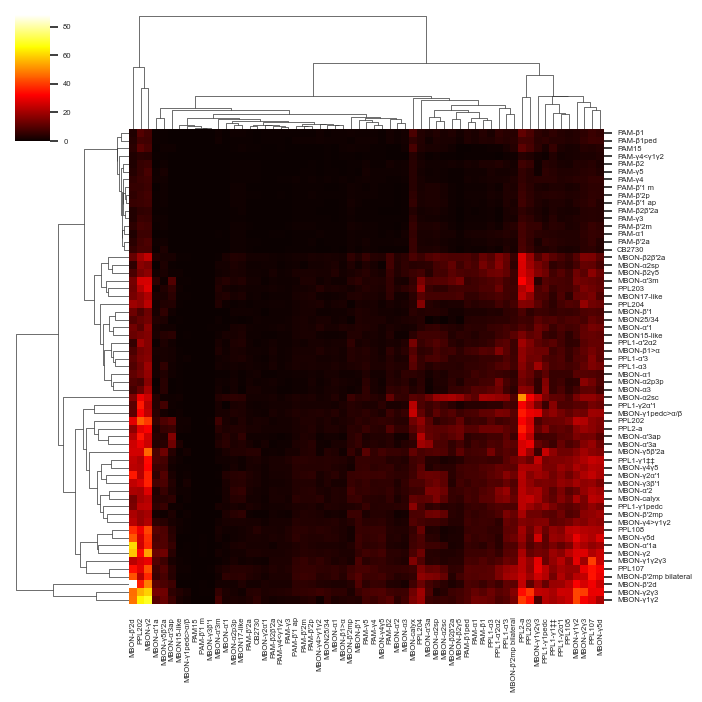

In [413]:
cmatrix = reduced_third_order.copy()
# cmatrix = np.log(cmatrix)
# cmatrix[cmatrix == -np.inf] = 0
# cmatrix[cmatrix < 0] = 0


sns.set(font_scale=0.5)
sns.clustermap(
    cmatrix, row_cluster=True, col_cluster=True, 
    cmap='hot', figsize=(7,7), 
    yticklabels=reduced_cell_types, xticklabels=reduced_cell_types,
)

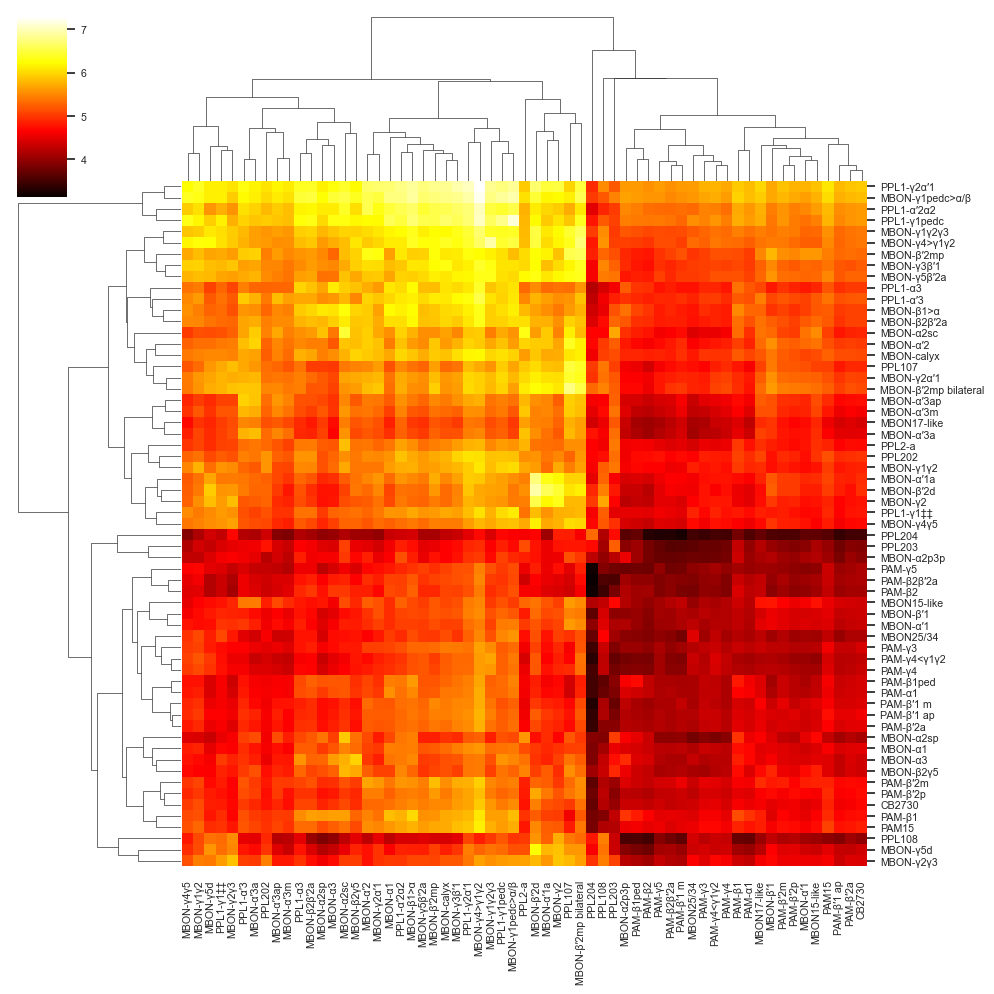

In [352]:
cmatrix = reduced_third_order.copy() + reduced_second_order.copy() + reduced_first_order.copy()
cmatrix = np.log(cmatrix)
cmatrix[cmatrix == -np.inf] = 0
cmatrix[cmatrix < 0] = 0

sns.set(font_scale=0.7)
sns.clustermap(
    cmatrix, row_cluster=True, col_cluster=True, 
    cmap='hot', figsize=(10,10),
    yticklabels=reduced_cell_types, xticklabels=reduced_cell_types,
)

/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_46949/2859675842.py:7: RuntimeWarning: divide by zero encountered in log10
  cmatrix = np.log10(cmatrix)


Detected communities (node: community):
PPL1-α′2α2: 0
PAM-β′2m: 0
PAM-β2β′2a: 0
PAM-β′2p: 4
PPL107: 4
PAM-β′1 ap: 0
PAM-β′1 m: 0
PPL1-α′3: 3
PPL1-γ2α′1: 0
PAM-β1: 0
PAM-β′2a: 0
PAM-γ4<γ1γ2: 0
CB2730: 0
PPL108: 4
PAM-β1ped: 0
PPL1-α3: 0
PAM-γ3: 0
PAM-γ4: 0
PAM15: 0
PPL1-γ1pedc: 0
PPL204: 1
PAM-β2: 2
PPL1-γ1‡‡: 4
PAM-α1: 0
PPL202: 0
PPL2-a: 3
PAM-γ5: 0
PPL203: 3
MBON-β′2mp: 3
MBON-α′2: 3
MBON-α1: 0
MBON-β1>α: 0
MBON-α′3ap: 3
MBON-γ2α′1: 4
MBON-β′2mp bilateral: 4
MBON-calyx: 4
MBON-β2β′2a: 3
MBON-α′1a: 4
MBON-α2sp: 3
MBON-γ3β′1: 4
MBON-α2p3p: 0
MBON-β′1: 4
MBON-α′3m: 3
MBON-γ1γ2γ3: 0
MBON-γ1pedc>α/β: 0
MBON-β′2d: 4
MBON-γ4>γ1γ2: 0
MBON-γ5d: 4
MBON-α2sc: 3
MBON-α3: 0
MBON-α′1: 0
MBON-γ2γ3: 4
MBON17-like: 3
MBON25/34: 0
MBON-α′3a: 3
MBON15-like: 3
MBON-γ4γ5: 4
MBON-γ5β′2a: 4
MBON-γ1γ2: 4
MBON-γ2: 4
MBON-β2γ5: 0


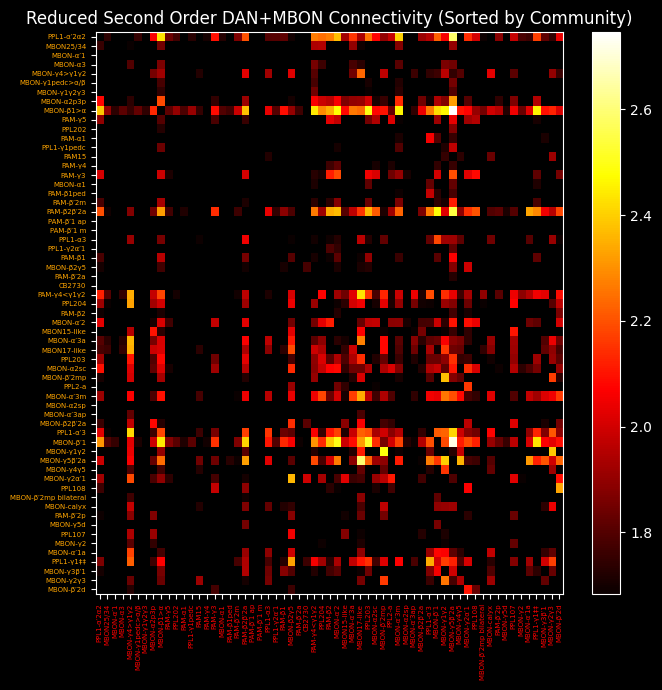

Computing transition probabilities:   0%|          | 0/61 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 323.49it/s]
/Users/neurorishika/Projects/Rockefeller/Ruta/fly-connectomics/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


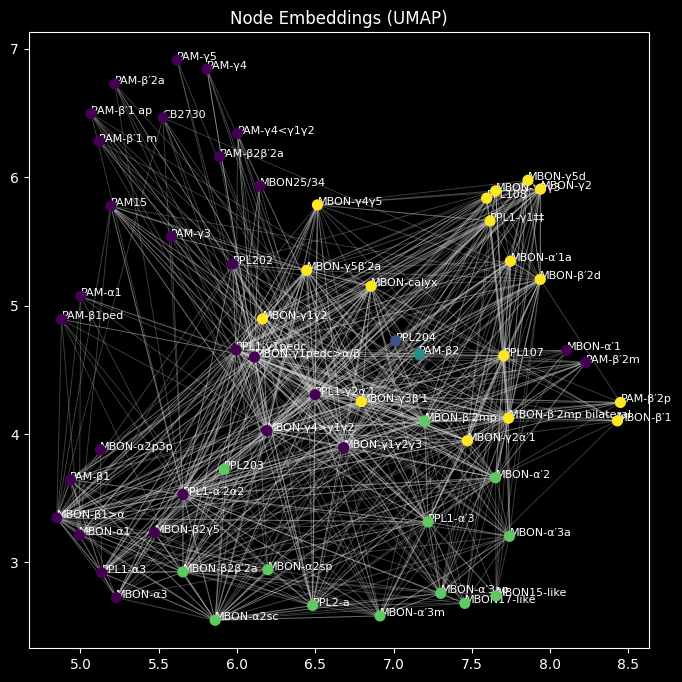

In [231]:
# --- Instead of using the full first-order matrix, use the reduced one ---
cmatrix = reduced_second_order.copy()
np.fill_diagonal(cmatrix, 0)
cmatrix[cmatrix < np.percentile(cmatrix, 75)] = 0

# log-transform the matrix
cmatrix = np.log10(cmatrix)
# set diagonal to 0

# create the graph using the reduced connectivity matrix
G = create_graph_from_matrix(cmatrix, reduced_cell_types, threshold=np.percentile(reduced_first_order, 75))

# detect communities using the reduced graph
partition = detect_communities(G)
print("Detected communities (node: community):")
for node, comm in partition.items():
    print(f"{node}: {comm}")

# sort matrix by communities and plot
sorted_indices = np.argsort(list(partition.values()))
sorted_cell_types = reduced_cell_types[sorted_indices]
sorted_second_order = cmatrix[sorted_indices][:, sorted_indices]
plot_reduced_connection_matrix(cmatrix, sorted_cell_types, "Reduced Second Order DAN+MBON Connectivity (Sorted by Community)")


# --- Network Embedding ---
embeddings = perform_node2vec_embedding(G, dimensions=64, walk_length=30, num_walks=200)

# Visualize the embedding using UMAP
plot_embedding(embeddings, partition, reduced_cell_types, cmatrix, threshold=np.percentile(cmatrix, 75))


In [ ]:
# investigate a single class in the form of cell types
N_steps_analysis = 5
for class_to_investigate in ['other descending']:
    # get the cell types across all layers
    class_neurons = []
    class_cell_types = []
    class_values = []
    for layer_no in range(N_steps_analysis+1):
        neurons = layers[layer_no]
        values = connectivitys[layer_no]
        classes = layer_classes[layer_no]

        # filter out the neurons that are not of the class
        class_mask = [c == class_to_investigate for c in classes]
        class_mask = np.array(class_mask)
        neurons = neurons[class_mask]
        values = values[class_mask]
        # get the cell types applying the neuron dictionary if available
        cell_type = [get_cell_type(n) for n in neurons]
        cell_type = [neuron_dictionary[c] if c in neuron_dictionary else c for c in cell_type]

        class_neurons.append(neurons)
        class_cell_types.append(cell_type)
        class_values.append(values)

    # get the unique cell types
    unique_cell_types = np.unique(np.concatenate(class_cell_types))
    n_cell_types = len(unique_cell_types)
    cell_type_to_index = {c:i for i,c in enumerate(unique_cell_types)}
    index_to_cell_type = {i:c for i,c in enumerate(unique_cell_types)}

    all_cell_type_values = []

    for layer_no in range(1,N_steps_analysis+1):

        neurons = class_neurons[layer_no]
        values = class_values[layer_no]
        cell_types = class_cell_types[layer_no]

        cell_type_ids = [cell_type_to_index[c] for c in cell_types]
        cell_type_ids = np.array(cell_type_ids)

        # get average connectivity for each cell type
        cell_type_values = np.zeros(n_cell_types)
        for i in range(n_cell_types):
            cell_type_values[i] = np.mean(np.abs(values[cell_type_ids == i])) if np.sum(cell_type_ids == i) > 0 else np.inf
        all_cell_type_values.append(np.power(cell_type_values, 1/layer_no))

        # sort the cell types by average connectivity
        sorted_indices = np.argsort(cell_type_values)

            
        max_value = 0
        # scatter plot of the values
        plt.figure(figsize=(5,5))

        sorted_values = cell_type_values[sorted_indices]
        # clean to remove inf values
        sorted_indices = np.array(sorted_indices)
        cleaned_sorted_indices = sorted_indices[sorted_values != np.inf]
        # put the top 20 cell types on the plot
        plt.text(-0.3, -2, 'Top 20 cell types', fontsize=12, ha='left', va='center')
        for n,i in enumerate(cleaned_sorted_indices[-20:][::-1]):
            # print(index_to_cell_type[i], cell_type_values[i])
            plt.text(-0.3, -5*(n+2), f"{index_to_cell_type[i]}: {cell_type_values[i]:.3f}", fontsize=8, ha='left', va='center', color=plt.cm.Oranges(i/n_cell_types))


        i = 0
        for idx in sorted_indices:
            if np.sum(cell_type_ids == idx) == 0:
                continue
            # get the values for the class
            cell_type_values = values[cell_type_ids == idx]
            # cell_type_values = np.power(np.abs(values[cell_type_ids == idx]), 1/layer_no)* np.sign(values[cell_type_ids == idx])
            # plot the values
            plt.scatter(cell_type_values, -i + 0.1*np.random.randn(len(cell_type_values)), color=plt.cm.Oranges(idx/n_cell_types), s=5)
            # put the name of the class next to the points
            # plt.text(np.nanmin(cell_type_values)-0.5*np.mean(np.abs(values)) if len(cell_type_values) > 0 else 0, -i, index_to_cell_type[idx], verticalalignment='center', horizontalalignment='right', fontsize=10, color=plt.cm.Oranges(idx/n_cell_types))
            # update max value
            max_value = max(max_value, np.nanmax(np.abs(cell_type_values))) if len(cell_type_values) > 0 else max_value
            i += 1
        # draw the zero line
        plt.axvline(0, color='white', linestyle='--', linewidth=0.5)
        plt.xlim(-max_value, max_value)
        plt.xlabel('Output value')
        plt.gca().set_yticks([])
        # plt.ylim(-n_cell_types, 1)
        plt.gca().spines['left'].set_visible(False) 
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.tight_layout()
        plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_connectivity_{}_layer_{}.pdf'.format(class_to_investigate, layer_no)), bbox_inches='tight', dpi=300)
        plt.show()

# get the average connectivity for each cell type and plot as a bar plot
all_cell_type_values = np.array(all_cell_type_values)
# replace inf values with nan
all_cell_type_values[all_cell_type_values == np.inf] = np.nan
average_cell_type_values = np.nanmean(np.array(all_cell_type_values), axis=0)
# sort the cell types by average connectivity
sorted_indices = np.argsort(average_cell_type_values)
# keep only keep the top 20 cell types
sorted_indices = sorted_indices[-20:]
# get top 20 cell types
top20_cell_types = [index_to_cell_type[i] for i in sorted_indices]
# plot the sorted cell types
plt.figure(figsize=(5,5))
plt.barh(np.arange(len(sorted_indices)), average_cell_type_values[sorted_indices], color=plt.cm.Oranges(np.linspace(0, 1, len(sorted_indices))))
plt.yticks(np.arange(len(sorted_indices)), [index_to_cell_type[i] for i in sorted_indices])
plt.xlabel('Average output value')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_connectivity_{}_top_20.pdf'.format(class_to_investigate)), bbox_inches='tight', dpi=300)
plt.show()



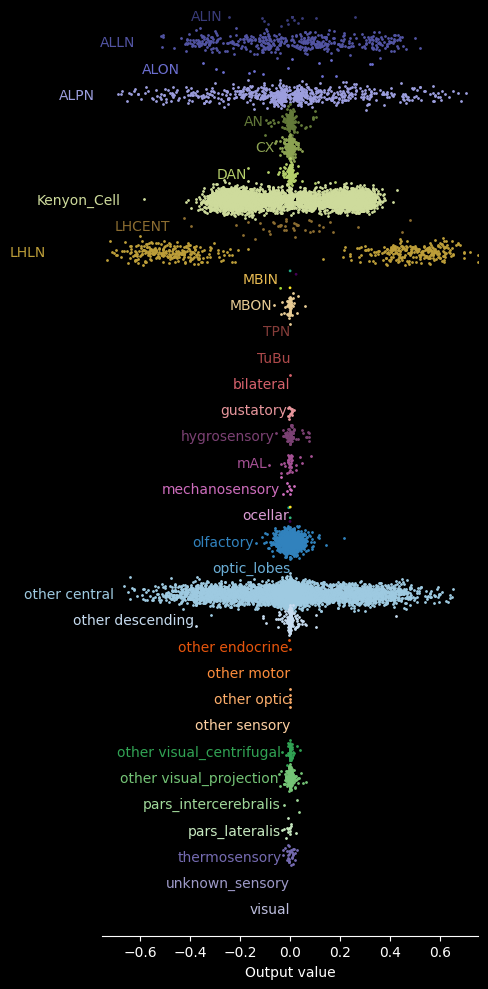

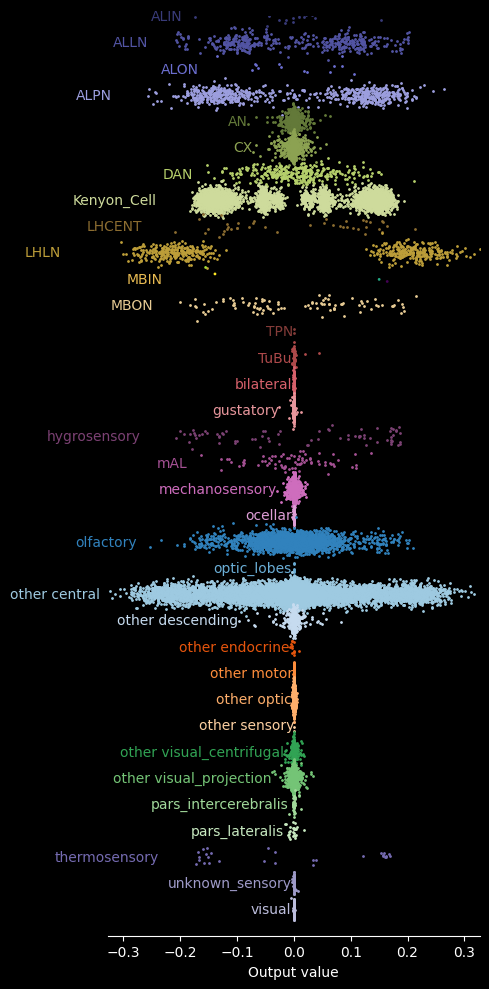

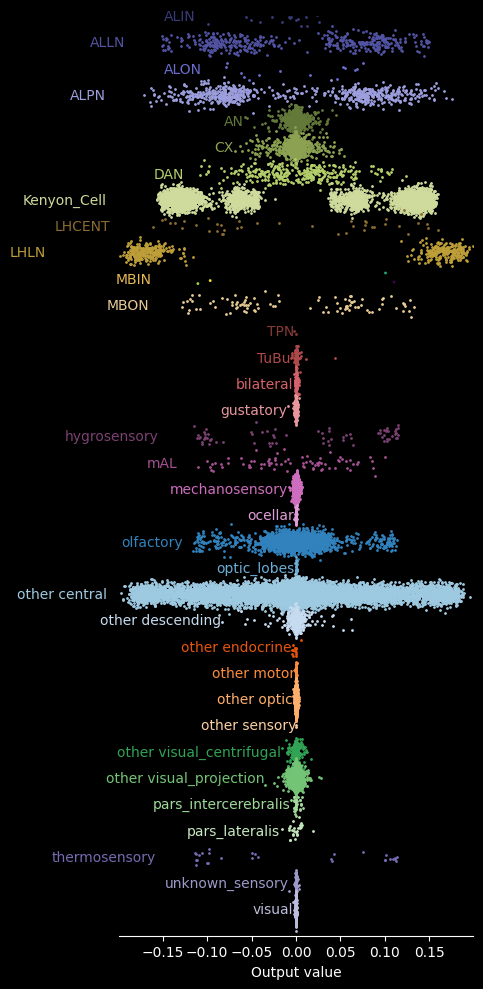

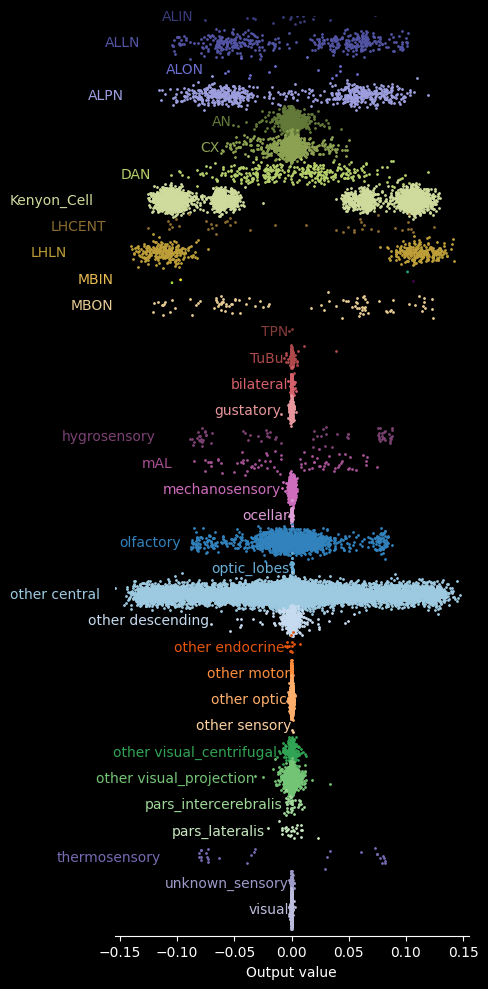

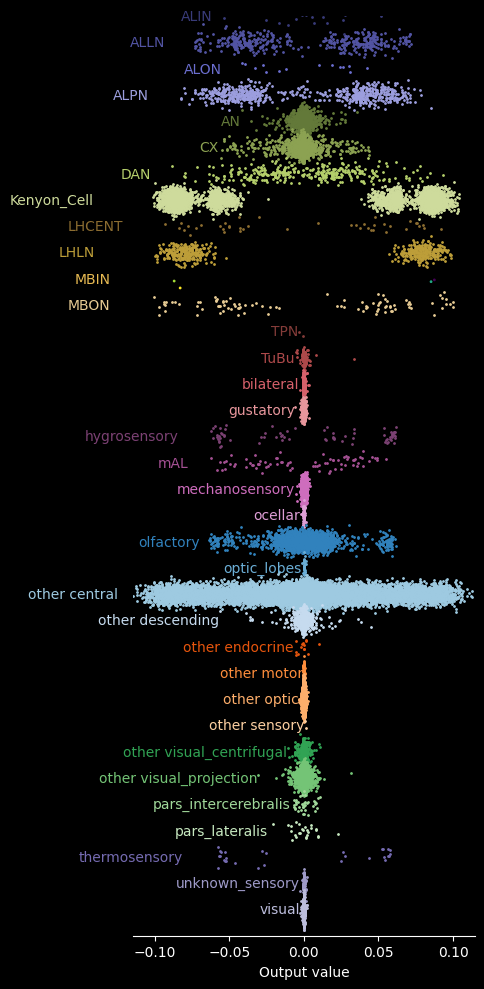

In [ ]:
visited_neurons = layers[0]
dont_display_visited_neurons = False

for layer_no in range(1,N_steps+1):

    classes = np.unique(classification['class'].values)

    n_classes = len(classes)
    class_to_index = {c:i for i,c in enumerate(classes)}
    index_to_class = {i:c for i,c in enumerate(classes)}
    
    neurons = layers[layer_no]
    values = connectivitys[layer_no]
    classes = layer_classes[layer_no]

    if dont_display_visited_neurons:
        mask = np.logical_not(np.isin(neurons, visited_neurons))
        neurons = neurons[mask]
        values = values[mask]

        # add the visited neurons to the visited neurons
        visited_neurons = np.concatenate((visited_neurons, neurons))
        # make sure the visited neurons are unique
        visited_neurons = np.unique(visited_neurons)

    class_ids = [class_to_index[c] for c in classes]
    class_ids = np.array(class_ids)

    # scatter plot of the values
    plt.figure(figsize=(5,10))
    for i in range(n_classes):
        # get the values for the class
        class_values = values[class_ids == i]
        # plot the values
        plt.scatter(class_values, -i + 0.2*np.random.randn(len(class_values)), c=cm_tab40(i), s=1)
        # put the name of the class next to the points
        plt.text(np.nanmin(class_values)-0.5*np.mean(np.abs(class_values)) if len(class_values) > 0 else 0, -i, index_to_class[i], verticalalignment='center', horizontalalignment='right', fontsize=10, color=cm_tab40(i))
    max_value = np.max(np.abs(values))
    plt.xlim(-max_value, max_value)
    plt.xlabel('Output value')
    plt.gca().set_yticks([])
    plt.ylim(-n_classes, 0)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'GRN_connectivity/NIP_GRN_connectivity_class_layer_{}.pdf'.format(layer_no)), bbox_inches='tight', dpi=300)
    plt.show()